In [2]:
#from mvp, build and run pipeline to generate .py files in src folder
#%%writefile src/obtain.py

# write functions that form a data pipeline, 
# then run this cell to save them in src/obtain.py

#use this at the end of the project to generate py files, import and run them from a main ftn for cleaner code

In [3]:
# import data pipeline functions from obtain.py
# def run_data_pipeline():
#     # call data pipeline functions in order
#     pass

# run_data_pipeline()

# Loading and cleaning text data
## Import libraries

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import sklearn
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

import nltk
import spacy #for faster tokenization and lemmatization

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import re
import string

import project4_functions

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Loading small dataset - What's Cooking
Kaggle 2MB What's Cooking data set - features: id, ingredients, cuisine type (target)

Use it to test cusine type classification. Should be able to use the best model on larger RecipeBox dataset after extracting ingredients.

*is there a way to out put probabilities of cuisine types? otherwise wouldn't get recipes from diff cuisines with the same ingredients* - predict_proba? or topic modelling and cluster by ingredient

In [5]:
#probably won't use it, not enough info? if can infer cuisine type from topics, don't need classfier?
#*or maybe check one against each other?

In [6]:
cdata = pd.read_json (r'/Users/xinrucheng/Documents/GitHub/metisproject04/data/raw/whats-cooking/train.json')

In [7]:
cdata.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [8]:
cdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
id             39774 non-null int64
cuisine        39774 non-null object
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


The small dataset has 39774 observations, and 3 features (id, cuisine, ingredients). We want to use it to build a cuisine-type classifier based on ingredients, and then hopefully apply it to the larger recipe box dataset (125000 observations). The source for the recipe box dataset includes cuisine type in tags, but the tags were not scraped (still have the option of scraping it if small classifier doesn't work?)

In [9]:
cdata['cuisine'].nunique()

20

So there are no null values, and there are 20 cuisine types for 39774 recipes in this dataset. That seems like it should be sufficient as a classifier for the larger dataset (can improve upon it later with scraped tags data).

In [10]:
cdata['cuisine'].unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

Looking at the 20 cuisine types in this data set, I think "british" and "irish" are a bit redundant (would've liked to have German instead of one of those; also mexican and cajun_creole probably have some overlaps also). I'll work with this for now, keeping in mind topic modelling and clustering on the bigger data set might lead to a different number of clusters.

In [11]:
#also recipe box repo has scraping code, if need to scrape more observations or tags

#before proceeding with the classifier, quickly inspect the recipe box data:

## Loading the RecipeBox dataset
*load into dict to store in MongoDB later?*

### allrecipes

In [12]:
#the three files are scraped from foodnetwork, epicurious, and allrecipes.com
#start with allrecipes.com - took 18.4s to load, can consider putting it into database?
rbdata_ar = pd.read_json(r'/Users/xinrucheng/Documents/GitHub/metisproject04/data/raw/recipes_raw/recipes_raw_nosource_ar.json')

In [13]:
rbdata_ar.head() #need to swap rows and columns
#features are title, ingredients, instructions, and picture_link(not needed?)

,rmK12Uau.ntP510KeImX506H6Mr6jTu,5ZpZE8hSVdPk2ZXo1mZTyoPWJRSCPSm,clyYQv.CplpwJtjNaFGhx0VilNYqRxu,BmqFAmCrDHiKNwX.IQzb0U/v0mLlxFu,N.jCksRjB4MFwbgPFQU8Kg.yF.XCtOi,kq.naD.8G19M4UU9dVvJgHtpfo.l/eC,lYrgWNn00EXblOupzM3tL0jGr9O0CB2,Fu0DgGYFUGwc0BBlN6r20o/ihOVs5bO,MBRNtqELRRuv8zJH4k7Aba2bmIc2A3C,ZPyPoMiNvgAfrKcRpH9FEYV/XsPZBsW,...,uHHb42/tuIKsmN5U6l9AD.FdVpSFxs6,IPAeN3L6rm2oughJpUhbG038k.ACJ0K,3UIhlTQFH5jyIaHN8zeKlK5V.94Kjwu,PdBxkE2gnI/.ynokkp1Hu1KLGZnGdei,SB46Udqc5Svsi70S1qRmRLv5tlg8Oca,gehEOcDPtU3SmNSXrwWwWD4ulPpUdMO,VRAsyF.1xMBYqAVKX1biyIORH6N6qzy,Lf8/u.0k2029QMSQFrHS4gRsvKOQFUG,ay.AqX/9ysBtWHcnHoDeGAyJ5Orla8e,2Q3Zpfgt/PUwn1YABjJ5A9T3ZW8xwVa
title,Slow Cooker Chicken and Dumplings,Awesome Slow Cooker Pot Roast,Brown Sugar Meatloaf,Best Chocolate Chip Cookies,Homemade Mac and Cheese Casserole,Banana Banana Bread,Chef John's Fisherman's Pie,Mom's Zucchini Bread,The Best Rolled Sugar Cookies,Singapore Chili Crabs,...,Citrus Creme Brulee,Honey Nutty Granola,Salmon en Croute,Homemade Blender Butter,Gluten Free Chicken Noodle Soup,Thai-Indian Veggie Soup,Coconut Milk-Free Panang Curry Chicken,Cooked Cold Salad,Easy Eggnog Creme Brulee,Super Power Stovetop Granola
ingredients,"[4 skinless, boneless chicken breast halves AD...",[2 (10.75 ounce) cans condensed cream of mushr...,"[1/2 cup packed brown sugar ADVERTISEMENT, 1/2...","[1 cup butter, softened ADVERTISEMENT, 1 cup w...",[8 ounces whole wheat rotini pasta ADVERTISEME...,"[2 cups all-purpose flour ADVERTISEMENT, 1 tea...","[For potato crust: ADVERTISEMENT, 3 russet pot...","[3 cups all-purpose flour ADVERTISEMENT, 1 tea...","[1 1/2 cups butter, softened ADVERTISEMENT, 2 ...","[Sauce: ADVERTISEMENT, 1/2 cup ketchup ADVERTI...",...,"[2 oranges, juiced ADVERTISEMENT, lemon, juice...","[3 cups rolled oats ADVERTISEMENT, 1 1/2 cups ...","[1 cup watercress, or as desired ADVERTISEMENT...","[2 pints heavy whipping cream ADVERTISEMENT, s...",[1/2 (12 ounce) box Barilla® Gluten Free Elbow...,"[2 teaspoons olive oil ADVERTISEMENT, 1/4 cup ...","[2 cups light cream ADVERTISEMENT, 1/4 teaspoo...","[3 tablespoons bacon grease ADVERTISEMENT, 2 c...","[4 egg yolks ADVERTISEMENT, 1 tablespoon white...","[1/4 cup canola oil ADVERTISEMENT, 3 cups quic..."
instructions,"Place the chicken, butter, soup, and onion in ...","In a slow cooker, mix cream of mushroom soup, ...",Preheat oven to 350 degrees F (175 degrees C)....,Preheat oven to 350 degrees F (175 degrees C)....,Preheat oven to 350 degrees F. Line a 2-quart ...,Preheat oven to 350 degrees F (175 degrees C)....,Bring a large saucepan of salted water and to ...,Grease and flour two 8 x 4 inch pans. Preheat ...,"In a large bowl, cream together butter and sug...","Whisk ketchup, chicken broth, egg, soy sauce, ...",...,Preheat oven to 300 degrees F (150 degrees C)....,Preheat oven to 300 degrees F (150 degrees C)....,Preheat oven to 375 degrees F (190 degrees C)....,Pour cream into a blender. Cover and blend unt...,Saute onions in olive oil over medium heat unt...,Heat oil in a large pot over medium heat. Add ...,Heat cream and coconut extract in a skillet or...,Heat bacon grease in a skillet over medium-hig...,Preheat oven to 350 degrees F (175 degrees C)....,Heat 1/4 cup canola oil in large skillet over ...
picture_link,55lznCYBbs2mT8BTx6BTkLhynGHzM.S,QyrvGdGNMBA2lDdciY0FjKu.77MM0Oe,LVW1DI0vtlCrpAhNSEQysE9i/7rJG56,0SO5kdWOV94j6EfAVwMMYRM3yNN8eRi,YCnbhplMgiraW4rUXcybgSEZinSgljm,jRnWGDXDdyOg3rta4/HVAR2rD19XubC,aUca10AaD8T2yYvcLOgH/UJlR5/OhOe,YdgEVyLVffZgh9NZPN3Eqj6MaX8KdzK,UrgvDGu4roLiho160fTVIwCUrGZna8i,OFp6yXFwzlrkMQ5STffYPllxQvMVLUS,...,qE58a7Z1Au0GXvPO188iHZZVqna9hLa,qE58a7Z1Au0GXvPO188iHZZVqna9hLa,qE58a7Z1Au0GXvPO188iHZZVqna9hLa,qE58a7Z1Au0GXvPO188iHZZVqna9hLa,cWEzUSv9Ozr3b4MxNVCqJYgTjIS.kHm,qE58a7Z1Au0GXvPO188iHZZVqna9hLa,qE58a7Z1Au0GXvPO188iHZZVqna9hLa,qE58a7Z1Au0GXvPO188iHZZVqna9hLa,qE58a7Z1Au0GXvPO188iHZZVqna9hLa,qE58a7Z1Au0GXvPO188iHZZVqna9hLa


In [14]:
rb_ar=rbdata_ar.T #can just do pandas transpose, don't need to set orient parameter in read_json!
rb_ar.head()

,title,ingredients,instructions,picture_link
rmK12Uau.ntP510KeImX506H6Mr6jTu,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves AD...","Place the chicken, butter, soup, and onion in ...",55lznCYBbs2mT8BTx6BTkLhynGHzM.S
5ZpZE8hSVdPk2ZXo1mZTyoPWJRSCPSm,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ...",QyrvGdGNMBA2lDdciY0FjKu.77MM0Oe
clyYQv.CplpwJtjNaFGhx0VilNYqRxu,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar ADVERTISEMENT, 1/2...",Preheat oven to 350 degrees F (175 degrees C)....,LVW1DI0vtlCrpAhNSEQysE9i/7rJG56
BmqFAmCrDHiKNwX.IQzb0U/v0mLlxFu,Best Chocolate Chip Cookies,"[1 cup butter, softened ADVERTISEMENT, 1 cup w...",Preheat oven to 350 degrees F (175 degrees C)....,0SO5kdWOV94j6EfAVwMMYRM3yNN8eRi
N.jCksRjB4MFwbgPFQU8Kg.yF.XCtOi,Homemade Mac and Cheese Casserole,[8 ounces whole wheat rotini pasta ADVERTISEME...,Preheat oven to 350 degrees F. Line a 2-quart ...,YCnbhplMgiraW4rUXcybgSEZinSgljm


In [15]:
rb_ar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39802 entries, rmK12Uau.ntP510KeImX506H6Mr6jTu to 2Q3Zpfgt/PUwn1YABjJ5A9T3ZW8xwVa
Data columns (total 4 columns):
title           39522 non-null object
ingredients     39522 non-null object
instructions    39522 non-null object
picture_link    39522 non-null object
dtypes: object(4)
memory usage: 2.8+ MB


The allrecipes.com portion of the RecipeBox dataset has 39522 recipes, similar in size to the small what's cooking dataset! Good for testing out classifer. Because total was ~125000, so that's about 1/3 of total (can check, the other 2 should be the same size)

In [16]:
#*total length 39802 observations, but only 39522 non-null for each feature? Need to drop rows with missing values
#dropped nulls in section 1.4.2

In [17]:
#reset index because don't want the scraped link as index
rb_ar.index = range(len(rb_ar))
rb_ar.head() 

,title,ingredients,instructions,picture_link
0,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves AD...","Place the chicken, butter, soup, and onion in ...",55lznCYBbs2mT8BTx6BTkLhynGHzM.S
1,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ...",QyrvGdGNMBA2lDdciY0FjKu.77MM0Oe
2,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar ADVERTISEMENT, 1/2...",Preheat oven to 350 degrees F (175 degrees C)....,LVW1DI0vtlCrpAhNSEQysE9i/7rJG56
3,Best Chocolate Chip Cookies,"[1 cup butter, softened ADVERTISEMENT, 1 cup w...",Preheat oven to 350 degrees F (175 degrees C)....,0SO5kdWOV94j6EfAVwMMYRM3yNN8eRi
4,Homemade Mac and Cheese Casserole,[8 ounces whole wheat rotini pasta ADVERTISEME...,Preheat oven to 350 degrees F. Line a 2-quart ...,YCnbhplMgiraW4rUXcybgSEZinSgljm


### epicurious

In [18]:
rbdata_epi = pd.read_json(r'/Users/xinrucheng/Documents/GitHub/metisproject04/data/raw/recipes_raw/recipes_raw_nosource_epi.json')

In [19]:
rb_epi=rbdata_epi.T

In [20]:
rb_epi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25323 entries, 05zEpbSqcs9E0rcnCJWyZ9OgdH0MLby to qznqHiNpq0AB1AYn002A2HvaEFnN0lq
Data columns (total 4 columns):
ingredients     25323 non-null object
picture_link    12119 non-null object
instructions    25323 non-null object
title           25323 non-null object
dtypes: object(4)
memory usage: 2.2+ MB


In [21]:
#only about half of the epicurious dataset has pictures, also this is the smallest dataset. 
#the columns are also in a different order
rb_epi.head()

,ingredients,picture_link,instructions,title
05zEpbSqcs9E0rcnCJWyZ9OgdH0MLby,"[12 egg whites, 12 egg yolks, 1 1/2 cups sugar...",None,"Beat the egg whites until stiff, gradually add...",Christmas Eggnog
mF5SZmoqxF4WtIlhLRvzuKk.z6s7P2S,"[18 fresh chestnuts, 2 1/2 pounds veal stew me...",None,Preheat oven to 400°F. Using small sharp knife...,"Veal, Carrot and Chestnut Ragoût"
oQV5D7cVbCFwmrDs3pBUv2y.AG0WV26,"[2 tablespoons unsalted butter, softened, 4 or...",3xjktRst3I5lDZ2Z5kTOtqQyzZFFN9u,Preheat the oven to 350°F. Spread the softened...,Caramelized Bread Pudding with Chocolate and C...
Z9seBJWaB5NkSp4DQHDnCAUBTwov/1u,"[3/4 pound Stilton, crumbled (about 3 cups) an...",None,"In a food processor blend the Stilton, the cre...",Sherried Stilton and Green Peppercorn Spread
bB3GxoAplVZeoX3fzWNWyeECtQFxw6G,"[2 cups (about 9 1/2 ounces) whole almonds, to...",None,Position rack in center of oven and preheat to...,Almond-Chocolate Macaroons


### foodnetwork

In [22]:
rbdata_fn = pd.read_json(r'/Users/xinrucheng/Documents/GitHub/metisproject04/data/raw/recipes_raw/recipes_raw_nosource_fn.json')

In [23]:
rb_fn=rbdata_fn.T

In [24]:
rb_fn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60039 entries, p3pKOD6jIHEcjf20CCXohP8uqkG5dGi to 7cXA77UpdDtIfBug2v6lEVIuV3Zcvhm
Data columns (total 4 columns):
instructions    59628 non-null object
ingredients     59802 non-null object
title           59750 non-null object
picture_link    30952 non-null object
dtypes: object(4)
memory usage: 4.8+ MB


This is the largest single-source dataset with 60039 entries, but it has many missing values. 
What could cause the most issues for out purposes is missing title and ingredients. It would make sense to drop the rows that do not have title or ingredients, and even the ones missing instructions. We won't likely need the picture link, so we can drop those columns for all three files in the recipebox dataset.

In [25]:
rb_fn.head()

,instructions,ingredients,title,picture_link
p3pKOD6jIHEcjf20CCXohP8uqkG5dGi,Toss ingredients lightly and spoon into a butt...,"[1/2 cup celery, finely chopped, 1 small green...",Grammie Hamblet's Deviled Crab,None
S7aeOIrsrgT0jLP32jKGg4j.o9zi2DO,Watch how to make this recipe.\nSprinkle the s...,"[2 pounds skirt steak, cut into 1/2-inch dice,...",Infineon Raceway Baked Beans,Ja5uaD8Q7m7vvtWwk2.48dr1eCre/qi
o9MItV9txfoPsUQ4v8b0vh1.VdjwfsK,"In a large saucepan, let the beans soak in eno...","[1 1/2 cups dried black beans, picked over and...",Southwestern Black Bean Dip,None
5l1yTSYFifF/M2dfbD6DX28WWQpLWNK,Watch how to make this recipe.\nPreheat the ov...,"[1 1/4 pounds ground chuck, One 15-ounce can t...",Sour Cream Noodle Bake,nm/WxalB.VjEZSa0iX9RuZ8xI51Y7bS
kRBQSWtqYWqtkb34FGeenBSbC32gIdO,Special equipment: sushi mat\nCook the brown r...,"[1 cup rice, brown, medium-grain, cooked, 1/2-...",Sushi Renovation,None


## Data cleaning

In [26]:
#drop id columns in what's cooking dataset, drop picture_link columns in all 3 recipebox datasets

#also drop missing values in foodnetwork and allrecipes data. wsc and epicurious do not have missing values

### clean small data set (what's cooking)

In [27]:
cdf=cdata.iloc[:,1:] #make new df, drop id column
cdf.head()

,cuisine,ingredients
0,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,"[water, vegetable oil, wheat, salt]"
4,indian,"[black pepper, shallots, cornflour, cayenne pe..."


### drop nulls from recipebox - fn and ar

1. Clean allrecipes data

In [28]:
ardf=rb_ar.loc[:,['title','ingredients','instructions']] #drop picture_link column
ardf.head()

,title,ingredients,instructions
0,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves AD...","Place the chicken, butter, soup, and onion in ..."
1,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ..."
2,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar ADVERTISEMENT, 1/2...",Preheat oven to 350 degrees F (175 degrees C)....
3,Best Chocolate Chip Cookies,"[1 cup butter, softened ADVERTISEMENT, 1 cup w...",Preheat oven to 350 degrees F (175 degrees C)....
4,Homemade Mac and Cheese Casserole,[8 ounces whole wheat rotini pasta ADVERTISEME...,Preheat oven to 350 degrees F. Line a 2-quart ...


In [29]:
ardf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39802 entries, 0 to 39801
Data columns (total 3 columns):
title           39522 non-null object
ingredients     39522 non-null object
instructions    39522 non-null object
dtypes: object(3)
memory usage: 933.0+ KB


In [30]:
#still has ~300 null rows? drop those also
ardf=ardf.dropna(how='any')
ardf


,title,ingredients,instructions
0,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves AD...","Place the chicken, butter, soup, and onion in ..."
1,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ..."
2,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar ADVERTISEMENT, 1/2...",Preheat oven to 350 degrees F (175 degrees C)....
3,Best Chocolate Chip Cookies,"[1 cup butter, softened ADVERTISEMENT, 1 cup w...",Preheat oven to 350 degrees F (175 degrees C)....
4,Homemade Mac and Cheese Casserole,[8 ounces whole wheat rotini pasta ADVERTISEME...,Preheat oven to 350 degrees F. Line a 2-quart ...
...,...,...,...
39797,Thai-Indian Veggie Soup,"[2 teaspoons olive oil ADVERTISEMENT, 1/4 cup ...",Heat oil in a large pot over medium heat. Add ...
39798,Coconut Milk-Free Panang Curry Chicken,"[2 cups light cream ADVERTISEMENT, 1/4 teaspoo...",Heat cream and coconut extract in a skillet or...
39799,Cooked Cold Salad,"[3 tablespoons bacon grease ADVERTISEMENT, 2 c...",Heat bacon grease in a skillet over medium-hig...
39800,Easy Eggnog Creme Brulee,"[4 egg yolks ADVERTISEMENT, 1 tablespoon white...",Preheat oven to 350 degrees F (175 degrees C)....


In [31]:
#Now have 39522 observations (recipes) with no null values

#*still need to get rid of link as well as punctuations before further processing

#also the word ADVERTISEMENT shows up a lot - filter it out

2. clean epicurious data

No missing values in other features, just drop picture_link column


In [32]:
epidf=rb_epi.loc[:,['title','ingredients','instructions']] #drop picture_link column
epidf.head()

,title,ingredients,instructions
05zEpbSqcs9E0rcnCJWyZ9OgdH0MLby,Christmas Eggnog,"[12 egg whites, 12 egg yolks, 1 1/2 cups sugar...","Beat the egg whites until stiff, gradually add..."
mF5SZmoqxF4WtIlhLRvzuKk.z6s7P2S,"Veal, Carrot and Chestnut Ragoût","[18 fresh chestnuts, 2 1/2 pounds veal stew me...",Preheat oven to 400°F. Using small sharp knife...
oQV5D7cVbCFwmrDs3pBUv2y.AG0WV26,Caramelized Bread Pudding with Chocolate and C...,"[2 tablespoons unsalted butter, softened, 4 or...",Preheat the oven to 350°F. Spread the softened...
Z9seBJWaB5NkSp4DQHDnCAUBTwov/1u,Sherried Stilton and Green Peppercorn Spread,"[3/4 pound Stilton, crumbled (about 3 cups) an...","In a food processor blend the Stilton, the cre..."
bB3GxoAplVZeoX3fzWNWyeECtQFxw6G,Almond-Chocolate Macaroons,"[2 cups (about 9 1/2 ounces) whole almonds, to...",Position rack in center of oven and preheat to...


In [33]:
epidf.info() #no nulls

<class 'pandas.core.frame.DataFrame'>
Index: 25323 entries, 05zEpbSqcs9E0rcnCJWyZ9OgdH0MLby to qznqHiNpq0AB1AYn002A2HvaEFnN0lq
Data columns (total 3 columns):
title           25323 non-null object
ingredients     25323 non-null object
instructions    25323 non-null object
dtypes: object(3)
memory usage: 2.0+ MB


3. clean food network data

drop picture_link column as well as nulls

In [34]:
fndf=rb_fn.loc[:,['title','ingredients','instructions']] #drop picture_link column
fndf.head()

,title,ingredients,instructions
p3pKOD6jIHEcjf20CCXohP8uqkG5dGi,Grammie Hamblet's Deviled Crab,"[1/2 cup celery, finely chopped, 1 small green...",Toss ingredients lightly and spoon into a butt...
S7aeOIrsrgT0jLP32jKGg4j.o9zi2DO,Infineon Raceway Baked Beans,"[2 pounds skirt steak, cut into 1/2-inch dice,...",Watch how to make this recipe.\nSprinkle the s...
o9MItV9txfoPsUQ4v8b0vh1.VdjwfsK,Southwestern Black Bean Dip,"[1 1/2 cups dried black beans, picked over and...","In a large saucepan, let the beans soak in eno..."
5l1yTSYFifF/M2dfbD6DX28WWQpLWNK,Sour Cream Noodle Bake,"[1 1/4 pounds ground chuck, One 15-ounce can t...",Watch how to make this recipe.\nPreheat the ov...
kRBQSWtqYWqtkb34FGeenBSbC32gIdO,Sushi Renovation,"[1 cup rice, brown, medium-grain, cooked, 1/2-...",Special equipment: sushi mat\nCook the brown r...


In [35]:
fndf.info() #check for nulls

<class 'pandas.core.frame.DataFrame'>
Index: 60039 entries, p3pKOD6jIHEcjf20CCXohP8uqkG5dGi to 7cXA77UpdDtIfBug2v6lEVIuV3Zcvhm
Data columns (total 3 columns):
title           59750 non-null object
ingredients     59802 non-null object
instructions    59628 non-null object
dtypes: object(3)
memory usage: 4.3+ MB


In [36]:
fndf=fndf.dropna(how='any') #drop nulls
fndf

,title,ingredients,instructions
p3pKOD6jIHEcjf20CCXohP8uqkG5dGi,Grammie Hamblet's Deviled Crab,"[1/2 cup celery, finely chopped, 1 small green...",Toss ingredients lightly and spoon into a butt...
S7aeOIrsrgT0jLP32jKGg4j.o9zi2DO,Infineon Raceway Baked Beans,"[2 pounds skirt steak, cut into 1/2-inch dice,...",Watch how to make this recipe.\nSprinkle the s...
o9MItV9txfoPsUQ4v8b0vh1.VdjwfsK,Southwestern Black Bean Dip,"[1 1/2 cups dried black beans, picked over and...","In a large saucepan, let the beans soak in eno..."
5l1yTSYFifF/M2dfbD6DX28WWQpLWNK,Sour Cream Noodle Bake,"[1 1/4 pounds ground chuck, One 15-ounce can t...",Watch how to make this recipe.\nPreheat the ov...
kRBQSWtqYWqtkb34FGeenBSbC32gIdO,Sushi Renovation,"[1 cup rice, brown, medium-grain, cooked, 1/2-...",Special equipment: sushi mat\nCook the brown r...
...,...,...,...
4bfMWxlbKhx/McJq/89k0SBdw.VvAzW,Summer Corn Salad,"[4 ears fresh corn, 2 heads Belgian endive, 2 ...",Watch how to make this recipe.\nPreheat a gril...
T8lWBA1fcVdjxhMSWuoAbGoy5Lj.A8m,Zucchini Stuffed Tomatoes,"[4 large plum tomatoes, Salt and sugar, 1 1/2 ...",Preheat the broiler. Cut the tomatoes in 1/2 c...
f/coffo2TMs2J2gq5nTOUIqH2TRAkui,Pepper Pasta Quick Cook,"[3 tablespoons olive oil, 2 tablespoons unsalt...",Heat the oil and butter in a large skillet ove...
q3aDJc4zoEF5QT4e7Mn.ieQwV.DyHwS,Chocolate Cake with Armagnac Ice Cream,"[8 ounces butter, 8 ounces bittersweet chocola...",Preheat oven to 350 degrees. On the top half o...


In [37]:
#merge recipe box data? now can use same code for cleaning text (regex, etc)

-------

# Preprocessing and Vectorize

## Custom stopwords

In [38]:
from nltk.corpus import stopwords 

In [39]:
set(stopwords.words('english')) #look at the nltk English stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [40]:
stopwords_nltk = stopwords.words('english')

In [41]:
len(stopwords_nltk)

179

In [42]:
stopwords_nltk.extend(['ADVERTISEMENT', 'advertisement']) #when run cell again, keeps getting extended
print(len(stopwords_nltk))

181


In [43]:
stopwords_nltk

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [44]:
#added advertisement to stopwords, next step is to remove numbers from data before Vectorization
#CountVectorizer removes punctuation and only keeps alphanumeric
#vectorizers and nltk tokenizer have options to set tokens with regex, or to remove stopwords

## Count Vectorizer
(also has stopwords)
start with all recipes 

Nov.6 regex combined with apply and dataframe not working for some reason, instead, add "ADVERTISEMENT" to stopwords!
Can also add more stopwords if have another reoccurring word that does not help with interpreting topic

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [46]:
#countVectorizer 
#Converts a collection of text documents to a matrix of token counts
#input is expected to be the sequence strings or bytes items are expected to be analyzed directly.

### Clean up columns with regex

In [47]:
#use test corpus for custom stopwords
corpus = ['Toss ingredients lightly and spoon into','ADVERTISEMENT','test-phrase[]','S7aeOIrsrgT0jLP32jKGg4j.o9zi2DO','Infineon Raceway Baked Beans','[2 pounds skirt steak, cut into 1/2-inch dice,...','Watch how to make this recipe.\nSprinkle the s...']
vectorizer = CountVectorizer(stop_words=stopwords_nltk)
X = vectorizer.fit_transform(corpus)
#print(vectorizer.get_feature_names())
X.shape

#issue with using stopwords (write blog?) https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words

(7, 22)

In [48]:
print(vectorizer.get_feature_names())

['baked', 'beans', 'cut', 'dice', 'inch', 'infineon', 'ingredients', 'lightly', 'make', 'o9zi2do', 'phrase', 'pounds', 'raceway', 'recipe', 's7aeoirsrgt0jlp32jkgg4j', 'skirt', 'spoon', 'sprinkle', 'steak', 'test', 'toss', 'watch']


In [49]:
project4_functions.regex_nodigits_new(corpus) #works with test docs, returns str with digits removed

"['Toss ingredients lightly and spoon into', 'ADVERTISEMENT', 'test-phrase[]', 'SaeOIrsrgTjLPjKGgj.oziDO', 'Infineon Raceway Baked Beans', '[ pounds skirt steak, cut into /-inch dice,...', 'Watch how to make this recipe.\\nSprinkle the s...']"

### Clean and vectorize allrecipes data

#### Reset index

In [50]:
#reset index of cleaned data frame because don't want the scraped link as index
ardf.index = range(len(ardf))
ardf.head() 

,title,ingredients,instructions
0,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves AD...","Place the chicken, butter, soup, and onion in ..."
1,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ..."
2,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar ADVERTISEMENT, 1/2...",Preheat oven to 350 degrees F (175 degrees C)....
3,Best Chocolate Chip Cookies,"[1 cup butter, softened ADVERTISEMENT, 1 cup w...",Preheat oven to 350 degrees F (175 degrees C)....
4,Homemade Mac and Cheese Casserole,[8 ounces whole wheat rotini pasta ADVERTISEME...,Preheat oven to 350 degrees F. Line a 2-quart ...


In [51]:
ardf['ingredients']

0        [4 skinless, boneless chicken breast halves AD...
1        [2 (10.75 ounce) cans condensed cream of mushr...
2        [1/2 cup packed brown sugar ADVERTISEMENT, 1/2...
3        [1 cup butter, softened ADVERTISEMENT, 1 cup w...
4        [8 ounces whole wheat rotini pasta ADVERTISEME...
                               ...                        
39517    [2 teaspoons olive oil ADVERTISEMENT, 1/4 cup ...
39518    [2 cups light cream ADVERTISEMENT, 1/4 teaspoo...
39519    [3 tablespoons bacon grease ADVERTISEMENT, 2 c...
39520    [4 egg yolks ADVERTISEMENT, 1 tablespoon white...
39521    [1/4 cup canola oil ADVERTISEMENT, 3 cups quic...
Name: ingredients, Length: 39522, dtype: object

### Remove digits using regex in ar-ingredients 

In [52]:
ar_ingr_mod=ardf['ingredients'].apply(project4_functions.regex_nodigits_new)
ar_ingr_mod

0        [' skinless, boneless chicken breast halves AD...
1        [' (. ounce) cans condensed cream of mushroom ...
2        ['/ cup packed brown sugar ADVERTISEMENT', '/ ...
3        [' cup butter, softened ADVERTISEMENT', ' cup ...
4        [' ounces whole wheat rotini pasta ADVERTISEME...
                               ...                        
39517    [' teaspoons olive oil ADVERTISEMENT', '/ cup ...
39518    [' cups light cream ADVERTISEMENT', '/ teaspoo...
39519    [' tablespoons bacon grease ADVERTISEMENT', ' ...
39520    [' egg yolks ADVERTISEMENT', ' tablespoon whit...
39521    ['/ cup canola oil ADVERTISEMENT', ' cups quic...
Name: ingredients, Length: 39522, dtype: object

In [53]:
len(ar_ingr_mod)

39522

### Count Vectorize ar_ingredients column

In [54]:
corpus = ar_ingr_mod
vectorizer = CountVectorizer(stop_words=stopwords_nltk)

#from TopicModeling/LSA example notebook:
doc_ar_ing = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

['abalone', 'absinthe', 'absolut', 'abuelita', 'ac', 'acado', 'acai', 'accent', 'accents', 'accompaniments', 'according', 'achiote', 'acid', 'acidity', 'acids', 'acini', 'acorn', 'across', 'act', 'active', 'activedry', 'adams', 'add', 'added', 'addition', 'additional', 'additions', 'adjust', 'adjustable', 'adobo', 'adzuki', 'aerated', 'african', 'agar', 'agave', 'age', 'aged', 'ahead', 'ahi', 'aid', 'aidells', 'aioli', 'air', 'airheads', 'aisle', 'aji', 'ajicitos', 'ajies', 'al', 'alaska', 'alaskan', 'albacore', 'alcaparrado', 'alcohol', 'alder', 'ale', 'aleppo', 'alessi', 'alexia', 'alfalfa', 'alfredo', 'alligator', 'allspice', 'allwhites', 'almond', 'almondmilk', 'almonds', 'almost', 'aloe', 'aloha', 'along', 'alouette', 'alphabet', 'already', 'alternative', 'alum', 'aluminum', 'amaranth', 'amaretti', 'amaretto', 'amarillo', 'amaro', 'amaz', 'amber', 'amberjack', 'amchoor', 'amchur', 'amer', 'american', 'amino', 'aminos', 'amish', 'ammonia', 'amontillado', 'amount', 'amsterdam', 'ana

In [55]:
type(doc_ar_ing)#vectorizer returns sparse matrix

scipy.sparse.csr.csr_matrix

In [56]:
doc_ar_ing 

<39522x4807 sparse matrix of type '<class 'numpy.int64'>'
	with 995824 stored elements in Compressed Sparse Row format>

------

### Clean and CountVectorize ar-instructions column
now clean and vectorize instructions column also; then vectorize title and proceed to dim reduction!

In [57]:
ar_inst_mod=ardf['instructions'].apply(project4_functions.regex_nodigits_new)
ar_inst_mod

0        Place the chicken, butter, soup, and onion in ...
1        In a slow cooker, mix cream of mushroom soup, ...
2        Preheat oven to  degrees F ( degrees C). Light...
3        Preheat oven to  degrees F ( degrees C).\nCrea...
4        Preheat oven to  degrees F. Line a -quart cass...
                               ...                        
39517    Heat oil in a large pot over medium heat. Add ...
39518    Heat cream and coconut extract in a skillet or...
39519    Heat bacon grease in a skillet over medium-hig...
39520    Preheat oven to  degrees F ( degrees C).\nWhis...
39521    Heat / cup canola oil in large skillet over me...
Name: instructions, Length: 39522, dtype: object

In [58]:
type(ar_inst_mod)

pandas.core.series.Series

In [59]:
size(ar_inst_mod)

39522

In [60]:
corpus_ins = ar_inst_mod
vectorizer = CountVectorizer(stop_words=stopwords_nltk)

doc_ar_ins = vectorizer.fit_transform(corpus_ins)
print(vectorizer.get_feature_names())

['abalone', 'able', 'absinthe', 'absolutely', 'absorb', 'absorbed', 'absorbency', 'absorbent', 'absorbing', 'absorbs', 'absorption', 'abut', 'acai', 'acaraje', 'accents', 'accident', 'accidentally', 'accommodate', 'accompanied', 'accompaniments', 'according', 'accordingly', 'accordion', 'account', 'accumulate', 'accumulated', 'accumulates', 'accumulating', 'accurate', 'achieve', 'achieved', 'achieves', 'achiote', 'acid', 'acidic', 'acidity', 'acids', 'acini', 'acorn', 'acquire', 'acquired', 'acquires', 'across', 'act', 'acting', 'action', 'activate', 'activated', 'activates', 'active', 'actively', 'activity', 'acto', 'acts', 'actual', 'actually', 'adaptable', 'adas', 'add', 'added', 'adding', 'addition', 'additional', 'additionally', 'additions', 'adds', 'adequately', 'adhere', 'adheres', 'adhering', 'aditional', 'adjacent', 'adjust', 'adjustable', 'adjusted', 'adjusting', 'adn', 'adobo', 'adsorbed', 'adult', 'advance', 'adzuki', 'aebleskiver', 'aerate', 'aerosol', 'afer', 'affect', 'a

In [61]:
##*getting same features as ingredients column??
#can we merge before vectorization?

In [62]:
type(doc_ar_ins)

scipy.sparse.csr.csr_matrix

## Merge Recipe box datasets (allrecipes, foodnetwork, epicurious), then Vectorize

### Reset index

In [63]:
ardf.head()

,title,ingredients,instructions
0,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves AD...","Place the chicken, butter, soup, and onion in ..."
1,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ..."
2,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar ADVERTISEMENT, 1/2...",Preheat oven to 350 degrees F (175 degrees C)....
3,Best Chocolate Chip Cookies,"[1 cup butter, softened ADVERTISEMENT, 1 cup w...",Preheat oven to 350 degrees F (175 degrees C)....
4,Homemade Mac and Cheese Casserole,[8 ounces whole wheat rotini pasta ADVERTISEME...,Preheat oven to 350 degrees F. Line a 2-quart ...


In [64]:
fndf.head()

,title,ingredients,instructions
p3pKOD6jIHEcjf20CCXohP8uqkG5dGi,Grammie Hamblet's Deviled Crab,"[1/2 cup celery, finely chopped, 1 small green...",Toss ingredients lightly and spoon into a butt...
S7aeOIrsrgT0jLP32jKGg4j.o9zi2DO,Infineon Raceway Baked Beans,"[2 pounds skirt steak, cut into 1/2-inch dice,...",Watch how to make this recipe.\nSprinkle the s...
o9MItV9txfoPsUQ4v8b0vh1.VdjwfsK,Southwestern Black Bean Dip,"[1 1/2 cups dried black beans, picked over and...","In a large saucepan, let the beans soak in eno..."
5l1yTSYFifF/M2dfbD6DX28WWQpLWNK,Sour Cream Noodle Bake,"[1 1/4 pounds ground chuck, One 15-ounce can t...",Watch how to make this recipe.\nPreheat the ov...
kRBQSWtqYWqtkb34FGeenBSbC32gIdO,Sushi Renovation,"[1 cup rice, brown, medium-grain, cooked, 1/2-...",Special equipment: sushi mat\nCook the brown r...


In [65]:
fndf.index = range(len(fndf))
fndf.head() 

,title,ingredients,instructions
0,Grammie Hamblet's Deviled Crab,"[1/2 cup celery, finely chopped, 1 small green...",Toss ingredients lightly and spoon into a butt...
1,Infineon Raceway Baked Beans,"[2 pounds skirt steak, cut into 1/2-inch dice,...",Watch how to make this recipe.\nSprinkle the s...
2,Southwestern Black Bean Dip,"[1 1/2 cups dried black beans, picked over and...","In a large saucepan, let the beans soak in eno..."
3,Sour Cream Noodle Bake,"[1 1/4 pounds ground chuck, One 15-ounce can t...",Watch how to make this recipe.\nPreheat the ov...
4,Sushi Renovation,"[1 cup rice, brown, medium-grain, cooked, 1/2-...",Special equipment: sushi mat\nCook the brown r...


In [66]:
epidf.head()

,title,ingredients,instructions
05zEpbSqcs9E0rcnCJWyZ9OgdH0MLby,Christmas Eggnog,"[12 egg whites, 12 egg yolks, 1 1/2 cups sugar...","Beat the egg whites until stiff, gradually add..."
mF5SZmoqxF4WtIlhLRvzuKk.z6s7P2S,"Veal, Carrot and Chestnut Ragoût","[18 fresh chestnuts, 2 1/2 pounds veal stew me...",Preheat oven to 400°F. Using small sharp knife...
oQV5D7cVbCFwmrDs3pBUv2y.AG0WV26,Caramelized Bread Pudding with Chocolate and C...,"[2 tablespoons unsalted butter, softened, 4 or...",Preheat the oven to 350°F. Spread the softened...
Z9seBJWaB5NkSp4DQHDnCAUBTwov/1u,Sherried Stilton and Green Peppercorn Spread,"[3/4 pound Stilton, crumbled (about 3 cups) an...","In a food processor blend the Stilton, the cre..."
bB3GxoAplVZeoX3fzWNWyeECtQFxw6G,Almond-Chocolate Macaroons,"[2 cups (about 9 1/2 ounces) whole almonds, to...",Position rack in center of oven and preheat to...


In [67]:
epidf.index = range(len(epidf))
epidf.head() 

,title,ingredients,instructions
0,Christmas Eggnog,"[12 egg whites, 12 egg yolks, 1 1/2 cups sugar...","Beat the egg whites until stiff, gradually add..."
1,"Veal, Carrot and Chestnut Ragoût","[18 fresh chestnuts, 2 1/2 pounds veal stew me...",Preheat oven to 400°F. Using small sharp knife...
2,Caramelized Bread Pudding with Chocolate and C...,"[2 tablespoons unsalted butter, softened, 4 or...",Preheat the oven to 350°F. Spread the softened...
3,Sherried Stilton and Green Peppercorn Spread,"[3/4 pound Stilton, crumbled (about 3 cups) an...","In a food processor blend the Stilton, the cre..."
4,Almond-Chocolate Macaroons,"[2 cups (about 9 1/2 ounces) whole almonds, to...",Position rack in center of oven and preheat to...


In [68]:
frames = [ardf, fndf, epidf]
data = pd.concat(frames)
data.head()

,title,ingredients,instructions
0,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves AD...","Place the chicken, butter, soup, and onion in ..."
1,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ..."
2,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar ADVERTISEMENT, 1/2...",Preheat oven to 350 degrees F (175 degrees C)....
3,Best Chocolate Chip Cookies,"[1 cup butter, softened ADVERTISEMENT, 1 cup w...",Preheat oven to 350 degrees F (175 degrees C)....
4,Homemade Mac and Cheese Casserole,[8 ounces whole wheat rotini pasta ADVERTISEME...,Preheat oven to 350 degrees F. Line a 2-quart ...


In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124473 entries, 0 to 25322
Data columns (total 3 columns):
title           124473 non-null object
ingredients     124473 non-null object
instructions    124473 non-null object
dtypes: object(3)
memory usage: 3.8+ MB


### Remove digits

In [70]:
data_ingr=data['ingredients'].apply(project4_functions.regex_nodigits_new)
data_ingr

0        [' skinless, boneless chicken breast halves AD...
1        [' (. ounce) cans condensed cream of mushroom ...
2        ['/ cup packed brown sugar ADVERTISEMENT', '/ ...
3        [' cup butter, softened ADVERTISEMENT', ' cup ...
4        [' ounces whole wheat rotini pasta ADVERTISEME...
                               ...                        
25318    [' cups (about) canned beef broth', ' cup lent...
25319    ['/ teaspoon turmeric', ' cups water', '/ poun...
25320    [' medium jalapeño, thinly sliced', ' garlic c...
25321    [' / cups almond flour or almond meal', '/ cup...
25322    [' / pounds plum tomatoes, coarsely chopped (s...
Name: ingredients, Length: 124473, dtype: object

In [71]:
data_instr=data['instructions'].apply(project4_functions.regex_nodigits_new)
data_instr

0        Place the chicken, butter, soup, and onion in ...
1        In a slow cooker, mix cream of mushroom soup, ...
2        Preheat oven to  degrees F ( degrees C). Light...
3        Preheat oven to  degrees F ( degrees C).\nCrea...
4        Preheat oven to  degrees F. Line a -quart cass...
                               ...                        
25318    Bring  cups broth and lentils to boil in large...
25319    Stir together turmeric,  / cups water, and pan...
25320    Marinate and cook the steak: Combine jalapeño,...
25321    Make the cakes: Preheat oven to °F. Line the c...
25322    Preheat oven to °F. Combine plum tomatoes, mus...
Name: instructions, Length: 124473, dtype: object

In [72]:
type(data_instr)

pandas.core.series.Series

----

#### Merge columns**omit? only use ingredients

In [73]:
#lengths of columns (pd Series) both 124473, concatenate on index of data_ingr
data_cleaned = pd.concat([data_ingr, data_instr], axis=1).reindex(data_ingr.index)


In [74]:
data_cleaned.head()

,ingredients,instructions
0,"[' skinless, boneless chicken breast halves AD...","Place the chicken, butter, soup, and onion in ..."
1,[' (. ounce) cans condensed cream of mushroom ...,"In a slow cooker, mix cream of mushroom soup, ..."
2,"['/ cup packed brown sugar ADVERTISEMENT', '/ ...",Preheat oven to degrees F ( degrees C). Light...
3,"[' cup butter, softened ADVERTISEMENT', ' cup ...",Preheat oven to degrees F ( degrees C).\nCrea...
4,[' ounces whole wheat rotini pasta ADVERTISEME...,Preheat oven to degrees F. Line a -quart cass...


In [75]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124473 entries, 0 to 25322
Data columns (total 2 columns):
ingredients     124473 non-null object
instructions    124473 non-null object
dtypes: object(2)
memory usage: 2.8+ MB


---

### Vectorize - Count Vectorizer

In [76]:
#only work with merge ingredients dataset (from all 3 sources) for now
corpus = data_ingr
ct_vectorizer = CountVectorizer(stop_words=stopwords_nltk)

#from TopicModeling/LSA example notebook:
ingr_ct = ct_vectorizer.fit_transform(corpus)
print(ct_vectorizer.get_feature_names())

#recipes have other languages?

['_about', '_gravié_ra', '_hoong', 'aa', 'aalborg', 'aale', 'aaron', 'aarons', 'aarti', 'aattachment', 'ab', 'abalone', 'abasco', 'abbaye', 'abita', 'able', 'abondance', 'aborio', 'aborrio', 'abruzzese', 'abruzzo', 'absente', 'absinth', 'absinthe', 'absolut', 'absolute', 'absolutely', 'absorb', 'abuelita', 'abura', 'aburaage', 'aburage', 'abut', 'ac', 'acacia', 'acado', 'acai', 'accent', 'accents', 'acceptable', 'accepted', 'access', 'accommodate', 'accompanied', 'accompaniment', 'accompaniments', 'accompany', 'accompanying', 'accordian', 'according', 'accordingly', 'accordion', 'accuracy', 'accurately', 'acerola', 'acetate', 'aceto', 'achieve', 'achilleos', 'achiote', 'achoite', 'acholado', 'acid', 'acidic', 'acidity', 'acidophilus', 'acids', 'acidulated', 'acini', 'acitron', 'ackee', 'ackees', 'acommpaniment', 'acorn', 'acorns', 'acquello', 'across', 'acrylic', 'act', 'acting', 'activa', 'activate', 'activated', 'active', 'activedry', 'acto', 'acts', 'actually', 'adam', 'adams', 'add

### Vectorize - TF-IDF
might work better, because want to choose words "unique" to this document

TF-IDF = (Term Frequency) * (Inverse Document Frequency)

(how often word occurs in this doc) * inverse of (how often this word occurs in all documents)

In [77]:
tf_vectorizer = TfidfVectorizer(stop_words=stopwords_nltk)
ingr_tfidf = tf_vectorizer.fit_transform(corpus)

print(tf_vectorizer.get_feature_names())

['_about', '_gravié_ra', '_hoong', 'aa', 'aalborg', 'aale', 'aaron', 'aarons', 'aarti', 'aattachment', 'ab', 'abalone', 'abasco', 'abbaye', 'abita', 'able', 'abondance', 'aborio', 'aborrio', 'abruzzese', 'abruzzo', 'absente', 'absinth', 'absinthe', 'absolut', 'absolute', 'absolutely', 'absorb', 'abuelita', 'abura', 'aburaage', 'aburage', 'abut', 'ac', 'acacia', 'acado', 'acai', 'accent', 'accents', 'acceptable', 'accepted', 'access', 'accommodate', 'accompanied', 'accompaniment', 'accompaniments', 'accompany', 'accompanying', 'accordian', 'according', 'accordingly', 'accordion', 'accuracy', 'accurately', 'acerola', 'acetate', 'aceto', 'achieve', 'achilleos', 'achiote', 'achoite', 'acholado', 'acid', 'acidic', 'acidity', 'acidophilus', 'acids', 'acidulated', 'acini', 'acitron', 'ackee', 'ackees', 'acommpaniment', 'acorn', 'acorns', 'acquello', 'across', 'acrylic', 'act', 'acting', 'activa', 'activate', 'activated', 'active', 'activedry', 'acto', 'acts', 'actually', 'adam', 'adams', 'add

------

# Dimensionality Reduction

## What's Cooking dataset

### Count-Vectorized LSA, wsc data, ingredients only
focus on ingredients because already know the 20 cuisine types in cuisine column, no new info there

In [78]:
c_cleaned=cdf['ingredients'].apply(project4_functions.regex_nodigits_new)
c_cleaned

0        ['romaine lettuce', 'black olives', 'grape tom...
1        ['plain flour', 'ground pepper', 'salt', 'toma...
2        ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...
3              ['water', 'vegetable oil', 'wheat', 'salt']
4        ['black pepper', 'shallots', 'cornflour', 'cay...
                               ...                        
39769    ['light brown sugar', 'granulated sugar', 'but...
39770    ['KRAFT Zesty Italian Dressing', 'purple onion...
39771    ['eggs', 'citrus fruit', 'raisins', 'sourdough...
39772    ['boneless chicken skinless thigh', 'minced ga...
39773    ['green chile', 'jalapeno chilies', 'onions', ...
Name: ingredients, Length: 39774, dtype: object

In [79]:
#using what's cooking dataset, explore topics

corpus = c_cleaned.astype(str)
vectorizer = CountVectorizer(stop_words=stopwords_nltk) #still need to get rid of numbers (why are there numbers?)

doc_c = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

['abalone', 'abbamele', 'absinthe', 'abura', 'acai', 'accent', 'accompaniment', 'achiote', 'acid', 'acini', 'ackee', 'acorn', 'acting', 'activ', 'active', 'added', 'adobo', 'adzuki', 'agar', 'agave', 'age', 'aged', 'ahi', 'aioli', 'ajinomoto', 'ajwain', 'aka', 'alaskan', 'albacore', 'alcohol', 'ale', 'aleppo', 'alexia', 'alfalfa', 'alfredo', 'allspice', 'almond', 'almondmilk', 'almonds', 'aloe', 'alphabet', 'alum', 'amaranth', 'amarena', 'amaretti', 'amaretto', 'amba', 'amber', 'amberjack', 'amchur', 'america', 'american', 'aminos', 'ammonium', 'amontillado', 'ampalaya', 'anaheim', 'anasazi', 'ancho', 'anchovies', 'anchovy', 'andouille', 'anejo', 'angel', 'anglaise', 'angled', 'angostura', 'angus', 'anise', 'anisette', 'anjou', 'annatto', 'aonori', 'apple', 'apples', 'applesauce', 'applewood', 'apricot', 'apricots', 'aquavit', 'arak', 'arame', 'arbol', 'arborio', 'arctic', 'arepa', 'argo', 'arhar', 'armagnac', 'arrabbiata', 'arrow', 'arrowroot', 'artichok', 'artichoke', 'artichokes', '

In [80]:
doc_c

<39774x2976 sparse matrix of type '<class 'numpy.int64'>'
	with 754861 stored elements in Compressed Sparse Row format>

LSA Latent Semantic Analysis is SVD in word space!

In [105]:
#dim reduction (LSA) on wsc data, ingredients column only:

lsa_c = TruncatedSVD(10)  
doc_topic = lsa_c.fit_transform(doc_c)
lsa_c.explained_variance_ratio_  #variance for topics!

array([0.05440058, 0.03903463, 0.03975168, 0.0337523 , 0.03071306,
       0.0252825 , 0.02304202, 0.02123011, 0.01853531, 0.01576159])

#### Topics

In [106]:
project4_functions.display_topics(lsa_c, vectorizer.get_feature_names(), 10)


Topic  0
pepper, oil, salt, ground, garlic, fresh, sauce, onions, black, chicken

Topic  1
sugar, flour, sauce, butter, eggs, purpose, water, baking, milk, large

Topic  2
sauce, oil, soy, sesame, rice, garlic, ginger, onions, chicken, green

Topic  3
fresh, juice, olive, lemon, chopped, cheese, lime, cloves, oil, parsley

Topic  4
ground, fresh, cumin, ginger, cilantro, juice, coriander, cinnamon, lime, turmeric

Topic  5
cheese, chicken, sauce, cream, shredded, ground, cilantro, onions, green, chopped

Topic  6
pepper, fresh, bell, green, juice, lime, red, chopped, cilantro, chicken

Topic  7
chicken, powder, oil, salt, broth, onions, tomatoes, olive, garlic, cumin

Topic  8
chicken, broth, ground, boneless, white, skinless, sodium, butter, wine, breasts

Topic  9
onions, green, water, fresh, butter, parsley, tomatoes, ground, celery, carrots


In [107]:
#if choose to show 5 components, just gives the first 5 (doesn't cluster the 10 into 5)
lsa_5 = TruncatedSVD(5)  
wsc5_topic = lsa_5.fit_transform(doc_c)
lsa_5.explained_variance_ratio_  #variance for topics!

array([0.05440058, 0.03903436, 0.03975157, 0.0337518 , 0.03071352])

In [108]:
project4_functions.display_topics(lsa_5, vectorizer.get_feature_names(), 20)


Topic  0
pepper, oil, salt, ground, garlic, fresh, sauce, onions, black, chicken, olive, red, cheese, green, tomatoes, chopped, sugar, cloves, water, powder

Topic  1
sugar, flour, sauce, butter, eggs, purpose, water, baking, milk, large, soy, powder, vanilla, salt, extract, cream, sesame, unsalted, brown, egg

Topic  2
sauce, oil, soy, sesame, rice, garlic, ginger, onions, chicken, green, fresh, vinegar, red, fish, lime, starch, vegetable, scallions, chili, carrots

Topic  3
fresh, juice, olive, lemon, chopped, cheese, lime, cloves, oil, parsley, basil, extra, virgin, cilantro, large, grated, parmesan, leaves, tomatoes, butter

Topic  4
ground, fresh, cumin, ginger, juice, cilantro, coriander, cinnamon, lime, turmeric, lemon, chili, sugar, powder, seeds, chopped, masala, coconut, garam, curry


If we look at more words in the top 5 topics, the category seems a bit clearer (I wonder if 20 topics will match the 20 cuisine types for this dataset)
 - Topic 0: salad, european/british?
 - Topic 1: baking, dessert
 - Topic 2: asian
 - Topic 3: italian/mediterranean, vegetarian?
 - Topic 4: indian, spices

In [109]:
Vt = pd.DataFrame(wsc5_topic.round(5))
Vt


,0,1,2,3,4
0,1.30061,-0.83698,-0.32914,-0.19783,-0.82118
1,2.86882,-0.32578,-1.31041,-1.21225,0.30219
2,2.38510,0.64349,0.64437,-0.82035,-0.60816
3,0.78730,0.42297,0.10153,0.06841,-0.05669
4,3.35492,-0.01204,-0.68079,-0.99827,0.40010
...,...,...,...,...,...
39769,1.35093,3.00748,-1.29059,0.31111,-0.38260
39770,1.06580,-0.73196,-0.45589,-0.16007,-1.03141
39771,1.32731,1.25583,-1.70535,-0.43950,1.07118
39772,2.94179,2.49936,1.77999,-0.02629,0.11759


In [110]:
type(Vt)

pandas.core.frame.DataFrame

#### *Cosine similarity

In [111]:
from sklearn.metrics.pairwise import cosine_similarity


In [115]:
cosine_similarity(doc_topic[1].reshape(1, -1),doc_topic).round(3) #*compare the second doc with the rest
#word-by-word, 10 topics
#prev. slow because comparing all vs all!

array([[0.612, 1.   , 0.536, ..., 0.66 , 0.262, 0.809]])

In [91]:
#without .reshape, get ValueError: Expected 2D array, got 1D array instead:
#array=[-0.83714 -0.3265   0.64379 ...  1.25648  2.50274 -0.84032].
#Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [116]:
cosine_similarity(lsa_c.transform(doc_c[1].reshape(1, -1)),lsa_c.transform(doc_c)).round(3) #more stable after lsa
#lsa, 10 topics
#second and last one have high cos similarity (0.92) after lsa, check contents?


array([[0.612, 1.   , 0.539, ..., 0.66 , 0.264, 0.807]])

the second document has cosine similarity of 1 with itself which makes sense. 

#### Compare recipes

In [ ]:
#Look at two documents that have high cosine similarity and determine if it makes sense 

In [117]:
c_cleaned[1]

"['plain flour', 'ground pepper', 'salt', 'tomatoes', 'ground black pepper', 'thyme', 'eggs', 'green tomatoes', 'yellow corn meal', 'milk', 'vegetable oil']"

In [118]:
c_cleaned[39773] #not similar in words before transform; choose doc from array before transform instead?

"['green chile', 'jalapeno chilies', 'onions', 'ground black pepper', 'salt', 'chopped cilantro fresh', 'green bell pepper', 'garlic', 'white sugar', 'roma tomatoes', 'celery', 'dried oregano']"

In [119]:
#cosine similarity 0.566 between doc 1 and 13; also documents are of different lengths
c_cleaned[13]#could be mexican cuisine?

"['ground cinnamon', 'fresh cilantro', 'chili powder', 'ground coriander', 'kosher salt', 'ground black pepper', 'garlic', 'plum tomatoes', 'avocado', 'lime juice', 'flank steak', 'salt', 'ground cumin', 'black pepper', 'olive oil', 'crushed red pepper flakes', 'onions']"

Don't have recipe titles in this dataset. They do have some similar ingredients but are not as similar as I expected. Mixing up black pepper with ground pepper; **also could probably filter out salt as a stopword?**


In [ ]:
#also have the same words occurring in multiple topics - double counting?

### Count-Vectorized, NMF, wsc data, ingredients

In [120]:
nmf_model = NMF(10) #docs in word space, do NMF with 10 components
doc_topic = nmf_model.fit_transform(doc_c) 

In [121]:
nmf_model.components_.shape  

(10, 2976)

In [123]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             columns = vectorizer.get_feature_names())
#topic_word #--too many features (words),this is not informative
#instead, can take dot product between two documents

'zest' in topics 1 and 3, 'zucchini' in topics 0, 5 and 6

In [124]:
project4_functions.display_topics(nmf_model, vectorizer.get_feature_names(), 10)
#similar 10 topics in LSA and NMF


Topic  0
pepper, red, black, bell, salt, garlic, onion, dried, cayenne, flakes

Topic  1
sugar, flour, butter, salt, purpose, eggs, large, milk, baking, water

Topic  2
sauce, oil, soy, sesame, sugar, rice, garlic, ginger, vinegar, water

Topic  3
fresh, juice, chopped, lemon, lime, cilantro, cloves, parsley, mint, basil

Topic  4
ground, black, cumin, cinnamon, pepper, coriander, ginger, salt, beef, cloves

Topic  5
cheese, parmesan, cream, shredded, grated, mozzarella, cheddar, sauce, basil, sour

Topic  6
oil, olive, garlic, salt, cloves, extra, tomatoes, virgin, wine, white

Topic  7
powder, cilantro, garlic, chili, salt, cumin, onion, lime, chilies, tomatoes

Topic  8
chicken, broth, boneless, skinless, breasts, sodium, low, breast, fat, halves

Topic  9
onions, green, tomatoes, water, rice, beans, garlic, diced, celery, carrots


Topics don't seem to be clearly divided, quite a few seem to be about spices/condiments. This might not be surprising because all we have in the what's cooking dataset are ingredients and cuisine types. Also this is just on the ingredients column.

In [125]:
#should add cuisine type column before LSA/NMF?* - but can only vectorize one column at a time, not entire df

----

In [ ]:
##write functions in python (VSC) then import functions into notebook**

### TF-IDF, wsc data

In [ ]:
#dim, new feature space, reduced features - can use for rec (cosine similarity, Euc dist, etc) -mvp

## Recipe Box (120k dataset)

treat rb data separately, or **clean and merge? easier (fewer permutations) if merged**
* CV+LSA
* CV+NMF
* TFIDF+LSA
* TFIDF+NMF
* LDA?
    * + Kmeans? then rec or just make rec based on cosine similarity (See NLP overview steps ppt)
    * topic classifer? visualize using t-SNE?

### Count Vectorized LSA, RB data

In [107]:
#dim reduction (LSA) on rb data, ingredients column only:

lsa_rb = TruncatedSVD(10)  
rb_lsa_topic = lsa_rb.fit_transform(ingr_ct)
lsa_rb.explained_variance_ratio_

array([0.0984525 , 0.06934334, 0.04334735, 0.0304743 , 0.02522839,
       0.02132279, 0.0191714 , 0.01757702, 0.01656075, 0.01563241])

In [108]:
project4_functions.display_topics(lsa_rb, ct_vectorizer.get_feature_names(), 10) 


Topic  0
cup, teaspoon, tablespoons, chopped, cups, salt, pepper, ground, fresh, tablespoon

Topic  1
chopped, pepper, fresh, tablespoons, oil, olive, garlic, black, freshly, tablespoon

Topic  2
teaspoon, ground, salt, powder, teaspoons, sugar, cups, tablespoons, baking, flour

Topic  3
tablespoons, cups, sugar, butter, ounces, unsalted, flour, large, cut, cream

Topic  4
chopped, cups, ounce, ounces, finely, cream, cheese, package, teaspoon, onion

Topic  5
cups, ounce, pepper, sliced, ounces, salt, black, cut, cheese, ground

Topic  6
ounce, tablespoons, package, cheese, ounces, cream, sauce, drained, taste, shredded

Topic  7
fresh, cut, inch, teaspoon, ounces, sliced, juice, peeled, ounce, pieces

Topic  8
tablespoon, sauce, cups, minced, sugar, powder, juice, teaspoons, fresh, water

Topic  9
ounces, tablespoon, freshly, ground, butter, salt, kosher, finely, cream, unsalted


CtVectorizer purely based on counts, quantities (teaspoons) show up the most! TF-IDF will make more sense

### TF-IDF, LSA

In [109]:
#TF-IDF from 2.3.4 above:
#vectorizer = TfidfVectorizer(stop_words=stopwords_nltk)
#ingr_tfidf = vectorizer.fit_transform(corpus)

lsa_rb_tf = TruncatedSVD(10)  
doc_topic = lsa_rb_tf.fit_transform(ingr_tfidf)
lsa_rb_tf.explained_variance_ratio_

array([0.01240815, 0.02918212, 0.01236641, 0.01123369, 0.00863622,
       0.00832236, 0.00799255, 0.00740317, 0.00694176, 0.00684952])

In [110]:
project4_functions.display_topics(lsa_rb_tf, tf_vectorizer.get_feature_names(), 10)
#restarted kernel, doesn't seem to have teaspoon in topics anymore? why?


Topic  0
cup, teaspoon, tablespoons, chopped, cups, ground, salt, tablespoon, pepper, sugar

Topic  1
sugar, cup, vanilla, baking, extract, flour, teaspoon, cups, purpose, butter

Topic  2
ounce, package, cheese, cream, cup, shredded, ounces, drained, mix, chocolate

Topic  3
teaspoon, ground, ounce, powder, pepper, taste, dried, onion, diced, sauce

Topic  4
cup, chopped, juice, fresh, white, lime, water, sugar, tablespoon, lemon

Topic  5
juice, ounce, lemon, teaspoon, tablespoon, orange, sauce, tablespoons, ounces, lime

Topic  6
cut, inch, sliced, cups, pieces, sauce, peeled, chicken, water, thinly

Topic  7
cup, cheese, sliced, parmesan, grated, shredded, taste, freshly, vinegar, sauce

Topic  8
tablespoons, cups, tablespoon, teaspoons, flour, minced, sauce, purpose, water, chicken

Topic  9
chocolate, tablespoons, sauce, chopped, cream, tablespoon, ounces, heavy, butter, finely


Compare with CountVectorizer topics above:
    
Topic  0
cup, teaspoon, tablespoons, chopped, cups, salt, pepper, ground, fresh, tablespoon

Topic  1
chopped, pepper, fresh, tablespoons, oil, olive, garlic, black, freshly, tablespoon

Topic  2
teaspoon, ground, salt, powder, teaspoons, sugar, cups, tablespoons, baking, flour

Topic  3
tablespoons, cups, sugar, butter, ounces, unsalted, flour, large, cut, cream

Topic  4
chopped, cups, ounce, ounces, finely, cream, cheese, package, teaspoon, onion

Topic  5
cups, ounce, pepper, sliced, ounces, salt, black, cut, cheese, ground

Topic  6
ounce, tablespoons, package, cheese, ounces, cream, sauce, drained, taste, shredded

Topic  7
fresh, cut, inch, teaspoon, ounces, sliced, juice, peeled, ounce, pieces

Topic  8
tablespoon, sauce, cups, minced, sugar, teaspoons, powder, juice, fresh, water

Topic  9
ounces, tablespoon, freshly, ground, butter, salt, kosher, finely, cream, unsalted

In [ ]:
#still get lots of tablespoons and cups, more cleaning
#put them into stopwords? table/teaspoons, cups, ounces
#OR: do stemming before tokenization? phrase tagging/lemmatization? only keep nouns of ingr names?

### Count Vectorized NMF, RB data

In [111]:
nmf_model = NMF(5) #docs in word space, do NMF with 2 components -- how to decide how many components?
ct_rb = nmf_model.fit_transform(ingr_ct) #columns are topics

In [129]:
project4_functions.display_topics(nmf_model, ct_vectorizer.get_feature_names(), 20)


Topic  0
carapelli, chana, algae, ajíes, chevrot, bistro, campbell, batata, apricots, bengali, baking, cornet, coiled, canada, apriums, bottles, copacola, capacola, asfoetida, consume

Topic  1
cleaver, bermudan, anchoy, chevrot, centenario, beanquinoa, briquettes, buttercake, africantradingco, converted, conchiglioni, comté, becoming, baerenjaeger, cauliflower, beak, amontillado, copacola, christophene, cornichon

Topic  2
chickweed, cambodian, churned, chimney, cleaver, charantes, bistro, blackeyed, consume, converted, coney, circle, chiffonnade, baba, bench, amontillado, arrowroot, castor, chilli, callets

Topic  3
bias, braggs, asfoetida, broiler, broths, assi, atomized, capfuls, butterground, aidells, broad, blackeyed, campbell, camphor, caraibe, cincinnati, bench, coiled, chana, cemita

Topic  4
boatswain, algae, balsam, assored, carapelli, ba, blackeyed, chevrot, ajies, atomized, commonly, calumet, acado, castor, bridge, capacola, colder, anyway, bib, apricots

Topic  5
ariel, 

In [ ]:
#**tune TF-IDF parameters? look into docs
#**also: GridSearchCV to find how many topics/ks to use?? sklearn doc example


## More preprocessing to get more meaningful topics
### Stemming/Lemmatization

> Stemming follows an algorithm with steps to perform on the words which makes it faster. Whereas, in lemmatization, you used WordNet corpus and a corpus for stop words as well to produce lemma which makes it slower than stemming. You also had to define a parts-of-speech to obtain the correct lemma (because sometimes one word can have multiple lemmas)

> Stemming and Lemmatization both generate the root form of the inflected words. The difference is that stem might not be an actual word, whereas lemma is an actual language word.

> For example, lemmatization would correctly identify the base form of ‘caring’ to ‘care’, whereas, stemming would cutoff the ‘ing’ part and convert it to car.

   > ‘Caring’ -> Lemmatization -> ‘Care’
   
   > ‘Caring’ -> Stemming -> ‘Car’
    


In [130]:
from nltk.stem import LancasterStemmer, PorterStemmer
lstemmer = LancasterStemmer()
# Try some stems 
print('drive: {}'.format(lstemmer.stem('drive')))  
print('drives: {}'.format(lstemmer.stem('drives')))  
print('driver: {}'.format(lstemmer.stem('driver')))  
print('drivers: {}'.format(lstemmer.stem('drivers')))  
print('driven: {}'.format(lstemmer.stem('driven')))

drive: driv
drives: driv
driver: driv
drivers: driv
driven: driv


In [131]:
print('tablespoon: {}'.format(lstemmer.stem('tablespoon')))  
print('tablespoons: {}'.format(lstemmer.stem('tablespoons')))  
print('ounce: {}'.format(lstemmer.stem('ounce')))  
print('ounces: {}'.format(lstemmer.stem('ounces')))  
print('cups: {}'.format(lstemmer.stem('cups')))
print('pounds: {}'.format(lstemmer.stem('pounds')))
#stemming doesn't change original data, just gives chopped result - how to use?

tablespoon: tablespoon
tablespoons: tablespoon
ounce: ount
ounces: ount
cups: cup
pounds: pound


In [132]:
pstemmer = PorterStemmer()
print('tablespoons: {}'.format(pstemmer.stem('tablespoons')))  
print('ounces: {}'.format(pstemmer.stem('ounces'))) 
#porterstemmer less agressive than lancaster

tablespoons: tablespoon
ounces: ounc


#### Test lemmatizer

In [133]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xinrucheng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [134]:
sentence = '''He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun. 
Two tablespoons of jam, not three ounces or three cups.'''
punctuations="?:!.,;"
sentence_words = nltk.word_tokenize(sentence)
for word in sentence_words:
    if word in punctuations:
        sentence_words.remove(word)

#sentence_words
for word in sentence_words:
    #print ("{0:20}{1:20}".format(word,wordnet_lemmatizer.lemmatize(word, pos="v")))
    print ("{0:20}{1:20}".format(word,wordnet_lemmatizer.lemmatize(word, pos="n")))
    

He                  He                  
was                 wa                  
running             running             
and                 and                 
eating              eating              
at                  at                  
same                same                
time                time                
He                  He                  
has                 ha                  
bad                 bad                 
habit               habit               
of                  of                  
swimming            swimming            
after               after               
playing             playing             
long                long                
hours               hour                
in                  in                  
the                 the                 
Sun                 Sun                 
Two                 Two                 
tablespoons         tablespoon          
of                  of                  
jam             

In [136]:
#lemmatization lower than stemming! is it worth it
type(data_ingr)

pandas.core.series.Series

In [137]:
lem_source = data_ingr
ingr_lem=[]
for word in lem_source:
    ingr_lem.append('{}'.format(word,wordnet_lemmatizer.lemmatize(word, pos="n")))
    
len(ingr_lem)

124473

In [138]:
ingr_lem[10]

"[' ( ounce) can pumpkin puree ADVERTISEMENT', ' eggs ADVERTISEMENT', ' cup vegetable oil ADVERTISEMENT', '/ cup water ADVERTISEMENT', ' cups white sugar ADVERTISEMENT', ' / cups all-purpose flour ADVERTISEMENT', ' teaspoons baking soda ADVERTISEMENT', ' / teaspoons salt ADVERTISEMENT', ' teaspoon ground cinnamon ADVERTISEMENT', ' teaspoon ground nutmeg ADVERTISEMENT', '/ teaspoon ground cloves ADVERTISEMENT', '/ teaspoon ground ginger ADVERTISEMENT', 'ADVERTISEMENT']"

### Add more stopwords before dim reduction
-- lemmatize first? before or after vectorizer*?

In [139]:
stopwords_ingr = stopwords_nltk #build upon previous custom stopwords (2.1) which included ADVERTISEMENT
stopwords_ingr.extend(['tablespoon', 'teaspoon', 'cup', 'ounce', 'pound', 'tablespoons', 'teaspoons', 'cups', 'ounces', 'pounds','inch','inches']) 
print(len(stopwords_ingr))#when run cell again, keeps getting extended

205


### TF-IDF, LSA, Lemmatized with new stopwords, RecipeBox

Try vectorizing corpus with newly extended stopwords, lemmatize before dim reduction

In [140]:
corpus_lem = ingr_lem #**do we have to tokenize before lemmatization? data type doesn't work otherwise

TF-IDF settings:
> max_df : float in range [0.0, 1.0] or int (default=1.0)
When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

> min_df : float in range [0.0, 1.0] or int (default=1)
When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

-- can set cutoffs to ignore the words that occur in almost every document, or just 1 or 2 documents (the latter might help remove one-time typos?)

In [141]:
tfc_vectorizer = TfidfVectorizer(max_df=0.98, min_df=2, stop_words=stopwords_ingr)#set cutoff for min/max
ingr_tfidf_n = tfc_vectorizer.fit_transform(corpus_lem)

print(tfc_vectorizer.get_feature_names())

['aa', 'aaron', 'ab', 'abalone', 'abita', 'able', 'aborio', 'abruzzese', 'absinthe', 'absolut', 'absolute', 'absolutely', 'absorb', 'abuelita', 'aburage', 'abut', 'ac', 'acacia', 'acai', 'accent', 'accents', 'acceptable', 'access', 'accommodate', 'accompanied', 'accompaniment', 'accompaniments', 'according', 'accordingly', 'accurately', 'acetate', 'aceto', 'achieve', 'achilleos', 'achiote', 'acid', 'acidic', 'acidity', 'acids', 'acidulated', 'acini', 'ackee', 'acorn', 'across', 'act', 'acting', 'activa', 'activated', 'active', 'acto', 'actually', 'adams', 'add', 'added', 'adding', 'addition', 'additional', 'additions', 'adds', 'ade', 'adjoining', 'adjust', 'adjustable', 'adjusted', 'adjusting', 'adobe', 'adobo', 'adriana', 'adrianascaravan', 'adult', 'adults', 'advance', 'adzuki', 'aerosol', 'afford', 'african', 'agar', 'agave', 'age', 'aged', 'agent', 'agitated', 'agnolotti', 'agricole', 'agrodolce', 'agua', 'aguardiente', 'ahead', 'ahi', 'aid', 'aidells', 'ail', 'aioli', 'air', 'airh

In [ ]:
#still doesn't account for typos (teaspooons), but they shouldn't occur frequently enough to affect TF-IDF?

In [157]:
lsa_rb_tf_lem = TruncatedSVD(10)  
lem_topic = lsa_rb_tf_lem.fit_transform(ingr_tfidf_n) #can set random_state? check doc and NMF example
lsa_rb_tf_lem.explained_variance_ratio_

array([0.01022549, 0.02768179, 0.01027987, 0.0093523 , 0.00852004,
       0.00807334, 0.00751141, 0.00700609, 0.00670395, 0.00617583])

In [143]:
project4_functions.display_topics(lsa_rb_tf_lem, tfc_vectorizer.get_feature_names(), 20)
#lemmatize/new stopwords didn't work when used before vectorizer/stopwords?
#added plurals (tablespoons) to stopwords for now
#*Order of op: tokenize (with stopwords), lemmatize, dim reduction?


Topic  0
chopped, ground, pepper, salt, fresh, oil, sugar, butter, black, garlic, olive, white, sliced, large, freshly, flour, minced, finely, onion, red

Topic  1
sugar, vanilla, baking, extract, flour, purpose, butter, eggs, milk, powder, chocolate, egg, soda, cream, white, unsalted, cinnamon, brown, softened, confectioners

Topic  2
fresh, lemon, juice, orange, leaves, plus, zest, extra, virgin, lime, olive, sugar, unsalted, kosher, large, finely, garnish, cut, freshly, mint

Topic  3
ground, baking, powder, salt, flour, freshly, oil, black, purpose, pepper, kosher, cinnamon, soda, olive, vinegar, brown, vegetable, virgin, extra, cloves

Topic  4
cheese, freshly, grated, parmesan, kosher, unsalted, extra, butter, olive, virgin, plus, room, temperature, black, cream, large, bread, salt, slices, shredded

Topic  5
chopped, finely, baking, fresh, parsley, chocolate, purpose, flour, soda, leaves, coarsely, tomatoes, extract, powder, walnuts, semisweet, chips, eggs, leaf, thyme

Topic  

In [ ]:
#would phrase tagging and removing adjectives help?
#still a lot of overlap between topics, but now more informative without words for quantities
#topic 5 seems strange (between 2 topics?)

In [144]:
Vt = pd.DataFrame(lem_topic.round(5))
Vt


,0,1,2,3,4,5,6,7,8,9
0,0.15872,-0.02593,-0.14160,-0.17266,-0.00832,-0.04717,-0.04524,0.04436,-0.13790,0.15992
1,0.08972,0.01385,-0.13849,-0.18243,-0.01310,-0.09866,0.02184,-0.03442,-0.00604,0.05342
2,0.30383,0.03572,-0.12807,0.11257,-0.03169,-0.00196,0.16005,0.16362,0.02823,-0.10259
3,0.33049,0.55690,-0.05791,0.01758,-0.13515,0.20246,-0.06956,-0.07241,0.18448,0.00066
4,0.27607,0.01936,-0.15145,-0.10957,0.16105,-0.02179,0.05694,-0.06983,-0.06723,0.00783
...,...,...,...,...,...,...,...,...,...,...
124468,0.29794,-0.15507,-0.14896,-0.18814,-0.11163,0.16849,-0.02169,0.00813,-0.02708,-0.03394
124469,0.26191,-0.06392,0.03369,-0.01599,-0.09007,0.11767,-0.01314,0.04959,-0.07204,-0.02963
124470,0.32736,-0.13935,0.11135,-0.02922,-0.07692,-0.06196,-0.02553,0.05474,0.00976,-0.12086
124471,0.31214,0.22036,0.30277,0.00186,0.08581,0.02120,0.21273,-0.14983,-0.15879,-0.00200


doc-topic matrix values really low? look at #3, 0.33085 in topic 0, 0.55702 in topic 1

> Topic  0
chopped, ground, pepper, salt, fresh, oil, sugar, butter, black, garlic, olive, white, sliced, large, freshly, flour, minced, finely, onion, red

> Topic  1
sugar, vanilla, baking, extract, flour, purpose, butter, eggs, milk, powder, chocolate, egg, soda, cream, white, unsalted, cinnamon, brown, softened, confectioners

In [145]:
ingr_lem[3]

"[' cup butter, softened ADVERTISEMENT', ' cup white sugar ADVERTISEMENT', ' cup packed brown sugar ADVERTISEMENT', ' eggs ADVERTISEMENT', ' teaspoons vanilla extract ADVERTISEMENT', ' cups all-purpose flour ADVERTISEMENT', ' teaspoon baking soda ADVERTISEMENT', ' teaspoons hot water ADVERTISEMENT', '/ teaspoon salt ADVERTISEMENT', ' cups semisweet chocolate chips ADVERTISEMENT', ' cup chopped walnuts ADVERTISEMENT', 'ADVERTISEMENT']"

In [146]:
data.iloc[3]

title                                 Best Chocolate Chip Cookies
ingredients     [1 cup butter, softened ADVERTISEMENT, 1 cup w...
instructions    Preheat oven to 350 degrees F (175 degrees C)....
Name: 3, dtype: object

The recipe that has the largest values in topics 0 and 1 is for chocolate chip cookies. It makes more sense for topic 1 (baking), not so much for topic 0. Although it does have butter, sugar, flour and salt which are in topic 0.

#### LSA-Cosine Similarity


In [147]:
type(ingr_lem)

list

In [148]:
type(lem_topic)

numpy.ndarray

In [149]:
type(ingr_tfidf_n)

scipy.sparse.csr.csr_matrix

cosine sim: from cos sim docs: input X, Y

X : ndarray or sparse array, shape: (n_samples_X, n_features) Input data.

Y : ndarray or sparse array, shape: (n_samples_Y, n_features) Input data. If None, the output will be the pairwise similarities between all samples in X.

#### Compare similar recipes

##### 1. Chocolate Chip Cookie

In [316]:
#for the same chocolate cookie recipe, see cosine similarity versus rest of the documents
data.iloc[3] 

title                                 Best Chocolate Chip Cookies
ingredients     [1 cup butter, softened ADVERTISEMENT, 1 cup w...
instructions    Preheat oven to 350 degrees F (175 degrees C)....
Name: 3, dtype: object

In [310]:
lsa_s_choc=cosine_similarity(lem_topic[3].reshape(1, -1), lem_topic).round(3)  #input of cos sim are nd arrays
#after lem, data type changed, get error when use ingr_lem in cos sim:  could not convert string to float
    #used lem_topic (doc-topic matrix) instead, reshaped for single sample, does output make sense?
lsa_s_choc

array([[0.017, 0.116, 0.396, ..., 0.086, 0.422, 0.085]])

In [311]:
#argsort returns sorted array pf indices with their values from low to high 
lsa_s_choc.argsort()

array([[ 78367,   4286, 116361, ...,     56,  11250,      3]])

In [312]:
#reverse array (-lsa_s)
(-lsa_s_choc).argsort()

array([[     3,  35999,  11250, ..., 116361,   4286,  78367]])

In [313]:
ingr_lem[3] 

"[' cup butter, softened ADVERTISEMENT', ' cup white sugar ADVERTISEMENT', ' cup packed brown sugar ADVERTISEMENT', ' eggs ADVERTISEMENT', ' teaspoons vanilla extract ADVERTISEMENT', ' cups all-purpose flour ADVERTISEMENT', ' teaspoon baking soda ADVERTISEMENT', ' teaspoons hot water ADVERTISEMENT', '/ teaspoon salt ADVERTISEMENT', ' cups semisweet chocolate chips ADVERTISEMENT', ' cup chopped walnuts ADVERTISEMENT', 'ADVERTISEMENT']"

In [314]:
ingr_lem[35999]

"[' cup butter, softened ADVERTISEMENT', '/ cup milk ADVERTISEMENT', ' teaspoon vanilla extract ADVERTISEMENT', ' / cups all-purpose flour ADVERTISEMENT', '/ cup brown sugar ADVERTISEMENT', '/ cup white sugar ADVERTISEMENT', ' teaspoon baking soda ADVERTISEMENT', ' teaspoon salt ADVERTISEMENT', ' cup chocolate chips ADVERTISEMENT', '/ cup chopped walnuts (optional) ADVERTISEMENT', 'ADVERTISEMENT']"

In [315]:
data.iloc[35999] 

title                          Edible Chocolate Chip Cookie Dough
ingredients     [1 cup butter, softened ADVERTISEMENT, 1/4 cup...
instructions    Mix butter, milk, and vanilla extract together...
Name: 35999, dtype: object

Yay! It worked! The recipe most similar to Best Chocolate Chip Cookies is Edible Chocolate Chip Cookie Dough

##### 2. Pot Roast

In [336]:
#check another recipe at random
lsa_s_pr=cosine_similarity(lem_topic[1].reshape(1, -1),lem_topic).round(3)
lsa_s_pr

array([[ 0.772,  1.   ,  0.149, ...,  0.151, -0.04 ,  0.273]])

In [337]:
data.iloc[1]

title                               Awesome Slow Cooker Pot Roast
ingredients     [2 (10.75 ounce) cans condensed cream of mushr...
instructions    In a slow cooker, mix cream of mushroom soup, ...
Name: 1, dtype: object

In [338]:
ingr_lem[1] 

"[' (. ounce) cans condensed cream of mushroom soup ADVERTISEMENT', ' ( ounce) package dry onion soup mix ADVERTISEMENT', ' / cups water ADVERTISEMENT', ' / pounds pot roast ADVERTISEMENT', 'ADVERTISEMENT']"

In [339]:
#sort indicies with cosine similarity from highest to lowest
(-lsa_s_pr).argsort()

array([[     1,    451,    766, ...,  55549, 118363,  76417]])

In [340]:
data.iloc[451]

title                                       Beef Tips and Noodles
ingredients     [1 pound sirloin tips, cubed ADVERTISEMENT, 1 ...
instructions    Preheat oven to 400 degrees F (200 degrees C)....
Name: 451, dtype: object

In [342]:
ingr_lem[451] #similar ingredients (beef, soup mix, mushrooms)

"[' pound sirloin tips, cubed ADVERTISEMENT', ' (. ounce) can condensed cream of mushroom soup ADVERTISEMENT', ' (. ounce) package beef with onion soup mix ADVERTISEMENT', ' (. ounce) can mushrooms, drained ADVERTISEMENT', ' cup water ADVERTISEMENT', ' ( ounce) package wide egg noodles ADVERTISEMENT', 'ADVERTISEMENT']"

In [344]:
data.iloc[766]

title                                    Slow Cooker London Broil
ingredients     [2 pounds flank steak ADVERTISEMENT, 1 (10.75 ...
instructions    Place meat in the bottom of the slow cooker; i...
Name: 766, dtype: object

In [345]:
ingr_lem[766] 

"[' pounds flank steak ADVERTISEMENT', ' (. ounce) can condensed cream of mushroom soup ADVERTISEMENT', ' (. ounce) can condensed tomato soup ADVERTISEMENT', ' ( ounce) package dry onion soup mix ADVERTISEMENT', 'ADVERTISEMENT']"

The top 3 recipes similar to Awesome Slow Cooker Pot Roast (including itself) are short and easy recipes using some pre-made ingredients such as canned soup. The second-most similar (Slow Cooker London Broil) is also a slow cooker recipe.

Also the model and seems to recognize beef, pot roast, and steak as similar (good!). This also shows we probably don't need to use soft cosine similarity (might try it in the future to see how "blurry" it makes things.

What abou least similar recipes?

In [346]:
data.iloc[76417] #wasn't expecting this (although the cooking process would be quite different)

title                                         Grilled Strip Steak
ingredients     [Extra-virgin olive oil, 4 (12 to 14-ounce) st...
instructions    Watch how to make this recipe.\nPreheat the gr...
Name: 36895, dtype: object

In [348]:
ingr_lem[76417] #They are also different because this has so few ingredients and is made from scratch

"['Extra-virgin olive oil', ' ( to -ounce) strip steaks', 'Kosher salt']"

In [347]:
data.iloc[118363] #this makes sense, granola is very different to pot roast

title                                              Lemon Granola 
ingredients     [1 cup old-fashioned rolled oats, 1/2 teaspoon...
instructions    1. Preheat the oven to 250°F. 2. Toss together...
Name: 19213, dtype: object

In [349]:
ingr_lem[118363]

"[' cup old-fashioned rolled oats', '/ teaspoon kosher salt', ' lemons:  zested,  juiced', '/ cup honey or agave nectar', ' tablespoons grapeseed or other neutral oil, plus more for the pan']"

##### 3. Tacos
Try another, more complicated recipe:

In [333]:
lsa_s_tacos = cosine_similarity(lem_topic[124470].reshape(1, -1),lem_topic).round(3) 
lsa_s_tacos

array([[0.176, 0.151, 0.533, ..., 1.   , 0.366, 0.773]])

In [367]:
#reverse array of indices, so see similarity from highest to lowest
lsa_ts=(-lsa_s_tacos).argsort()
lsa_ts

array([[124470,  96083,  33373, ...,   2522,  86678, 113423]])

In [319]:
data.iloc[124470]

title              Jalapeño and Lime–Marinated Skirt Steak Tacos 
ingredients     [1 medium jalapeño, thinly sliced, 2 garlic cl...
instructions    Marinate and cook the steak: Combine jalapeño,...
Name: 25320, dtype: object

In [322]:
ingr_lem[124470]

"[' medium jalapeño, thinly sliced', ' garlic cloves, finely chopped', '/ cup coarsely chopped cilantro', '/ cup fresh lime juice', '/ cup olive oil', ' teaspoon kosher salt', '/ teaspoon freshly ground black pepper', '/ teaspoon ground cumin', ' pound skirt steak, cut crosswise into –-inch segments', ' (-inch) corn tortillas', 'Homemade or store-bought tomatillo salsa (for serving)', '/ medium avocado, sliced', '/ cup sour cream, thinned with a tablespoon of water or lime juice', 'Crumbled queso fresco (optional), cilantro leaves, thinly sliced red onion, and lime wedges (for serving)']"

In [320]:
data.iloc[96083]

title                                               Nachos My Way
ingredients     [3 large heirloom tomatoes (about 2 1/2 pounds...
instructions    Make the salsa: Roughly chop the tomatoes, oni...
Name: 56561, dtype: object

The recipe most similar to tacos is nachos! Look into ingredients:

In [321]:
ingr_lem[96083]

"[' large heirloom tomatoes (about  / pounds), cored', ' large red onion', ' serrano chile pepper, stemmed', ' cup fresh cilantro (leaves and stems)', ' tablespoon Mexican beer (drink the rest!)', 'Juice of  lime', 'Kosher salt and freshly ground pepper', ' to  ounces nduja (soft Italian salami; available at boccalone.com)', ' -to--ounce bag white corn tortilla chips', ' bunch scallions, thinly sliced', ' cups canned pinto beans, drained and rinsed', 'Finely grated zest of  lime', ' radishes, thinly sliced', ' cup queso fresco', ' cup fresh corn kernels', ' tablespoons pickled jalapeno slices, drained, or more to taste', ' hass avocados', '/ cup fresh cilantro leaves']"

In [324]:
data.iloc[33373] #2rd most similar 

title                                    Avocado Watermelon Salad
ingredients     [4 cups cubed watermelon ADVERTISEMENT, 4 cups...
instructions    Combine watermelon, spinach, and avocados toge...
Name: 33373, dtype: object

In [325]:
ingr_lem[33373] #same cuisine type, overlap of ingredients

"[' cups cubed watermelon ADVERTISEMENT', ' cups fresh baby spinach, torn ADVERTISEMENT', ' large avocados - peeled, pitted, and diced ADVERTISEMENT', '/ cup walnut oil ADVERTISEMENT', '/ cup olive oil ADVERTISEMENT', ' lime, juiced ADVERTISEMENT', '/ teaspoon sweet paprika ADVERTISEMENT', 'ADVERTISEMENT']"

In [327]:
#least similar recipe:
data.iloc[113423]

title                                  Quark (Sour Fresh Cheese) 
ingredients                            [8 1/2 cups/2L buttermilk]
instructions    Preheat the oven to 150°F/65°C. Pour the butte...
Name: 14273, dtype: object

In [328]:
ingr_lem[113423] 

"[' / cups/L buttermilk']"

The only ingredient is buttermilk, no overlap in topics/ingredients or cuisine type with tacos.

Take a quick glance at the most similar and least similar recipes to "Jalapeño and Lime–Marinated Skirt Steak Tacos" with our 10 LSA topics

In [369]:
data.iloc[lsa_ts[0]]

,title,ingredients,instructions
25320,Jalapeño and Lime–Marinated Skirt Steak Tacos,"[1 medium jalapeño, thinly sliced, 2 garlic cl...","Marinate and cook the steak: Combine jalapeño,..."
56561,Nachos My Way,[3 large heirloom tomatoes (about 2 1/2 pounds...,"Make the salsa: Roughly chop the tomatoes, oni..."
33373,Avocado Watermelon Salad,"[4 cups cubed watermelon ADVERTISEMENT, 4 cups...","Combine watermelon, spinach, and avocados toge..."
51708,Coconut Red Curry Sauce and Noodles,"[1 tablespoon canola oil, 1/2 cup stemmed and ...",Heat the oil in a small saucepan over medium h...
26899,Green Bean and Bass Pouches,"[1 pound trimmed fresh green beans, 1 small re...",Preheat the oven to 425 degrees F.\nCut off 4 ...
...,...,...,...
3266,Baked Potato,"[1 baking potato ADVERTISEMENT, ADVERTISEMENT]",Preheat oven to 350 degrees F (175 degrees C)....
6959,Sadie's Buttermilk Biscuits,"[4 cups all-purpose flour ADVERTISEMENT, 1 tea...",Preheat oven to 450 degrees F (230 degrees C)....
2522,Fluffy Canadian Pancakes,"[1 cup all-purpose flour ADVERTISEMENT, 1 tabl...","In a medium bowl, combine flour and baking pow..."
47156,Chocolate Flowers/Ribbon Decoration,"[Chocolate plastic, Cocoa powder]",Note: 1 pound of chocolate plastic will decora...


In [174]:

#**grid search for LSA?NMF parameters? how many topics (k)
    # "if words repeated across docs, k is likely too large?"
    #**number of components (k) doesn't seem to change what words go into the top k topics which doesn't make sense
#clustering? 

### TF-IDF, NMF, Lemmatized

In [350]:
#corpus_lem =ingr_lem
#tf_c_vectorizer = TfidfVectorizer(max_df=0.98, min_df=2, stop_words=stopwords_ingr)#set cutoff for min/max
ingr_tfidf_n = tfc_vectorizer.fit_transform(corpus_lem)

print(tfc_vectorizer.get_feature_names()) #same as LSA above

['aa', 'aaron', 'ab', 'abalone', 'abita', 'able', 'aborio', 'abruzzese', 'absinthe', 'absolut', 'absolute', 'absolutely', 'absorb', 'abuelita', 'aburage', 'abut', 'ac', 'acacia', 'acai', 'accent', 'accents', 'acceptable', 'access', 'accommodate', 'accompanied', 'accompaniment', 'accompaniments', 'according', 'accordingly', 'accurately', 'acetate', 'aceto', 'achieve', 'achilleos', 'achiote', 'acid', 'acidic', 'acidity', 'acids', 'acidulated', 'acini', 'ackee', 'acorn', 'across', 'act', 'acting', 'activa', 'activated', 'active', 'acto', 'actually', 'adams', 'add', 'added', 'adding', 'addition', 'additional', 'additions', 'adds', 'ade', 'adjoining', 'adjust', 'adjustable', 'adjusted', 'adjusting', 'adobe', 'adobo', 'adriana', 'adrianascaravan', 'adult', 'adults', 'advance', 'adzuki', 'aerosol', 'afford', 'african', 'agar', 'agave', 'age', 'aged', 'agent', 'agitated', 'agnolotti', 'agricole', 'agrodolce', 'agua', 'aguardiente', 'ahead', 'ahi', 'aid', 'aidells', 'ail', 'aioli', 'air', 'airh

In [351]:
nmf_model = NMF(n_components=10, random_state=5,
          alpha=.1, l1_ratio=.5) #sklearn example - tune parameters? find optimal k with grid search
#random_state doesn't seem to affect which words show up in topics very much
lem_nmf_topic = nmf_model.fit_transform(ingr_tfidf_n) 
#why is execution much slower than LSA?

In [352]:
type(lem_nmf_topic)

numpy.ndarray

In [353]:
project4_functions.display_topics(nmf_model, tfc_vectorizer.get_feature_names(), 20)


Topic  0
diced, taste, pepper, onion, bell, red, tomatoes, minced, green, beans, drained, garlic, dried, seeded, salt, peppers, cans, tomato, black, corn

Topic  1
vanilla, sugar, extract, chocolate, cream, butter, unsalted, room, temperature, heavy, egg, milk, large, confectioners, semisweet, chips, unsweetened, pure, granulated, plus

Topic  2
juice, lemon, fresh, orange, lime, zest, sugar, ice, garnish, grated, water, mint, pineapple, fluid, peel, squeezed, frozen, cubes, chilled, vodka

Topic  3
cheese, shredded, package, cream, cheddar, grated, parmesan, frozen, mix, sour, bread, slices, milk, thawed, mozzarella, softened, soup, drained, eggs, condensed

Topic  4
ground, black, pepper, freshly, salt, kosher, cinnamon, nutmeg, pinch, cumin, cayenne, paprika, mustard, beef, allspice, cloves, butter, coriander, potatoes, pork

Topic  5
chopped, finely, fresh, parsley, onion, coarsely, leaves, celery, chicken, cilantro, broth, green, medium, thyme, leaf, peeled, onions, cloves, garli

--NMF topics seem a bit more independent (better separated) than LSA ones?

Summarising NMF topics (manual summary) -- Aside: can also find and visualize which words have the most weight in each topic? (LDA/Gensim example, topic modelling)

0. veg dish, mexican?
1. baking, cookies
2. drinks, cocktails
3. dairy, cheese&bread, european?
4. spices, pork dish, stew? European?
5. herbs, chicken
6. potatoes (*verbs here need to be lemmatized?)
7. baking, pastries
8. condiments, herbs, dressing?
9. chicken dish, spices/condiments, asian?


#### NMF-Cosine Similarity

Try the same recipe as LSA cosine similarity code above (section 3.3.3.1), see if recommendations are different, and which is better

##### 1. Tacos

In [355]:
nmf_s_tacos=cosine_similarity(lem_nmf_topic[124470].reshape(1, -1),lem_nmf_topic).round(3)  #corpus = ingr_lem
nmf_s_tacos

array([[0.244, 0.066, 0.479, ..., 1.   , 0.492, 0.749]])

In [362]:
data.iloc[124470]

title              Jalapeño and Lime–Marinated Skirt Steak Tacos 
ingredients     [1 medium jalapeño, thinly sliced, 2 garlic cl...
instructions    Marinate and cook the steak: Combine jalapeño,...
Name: 25320, dtype: object

In [363]:
ingr_lem[124470] 

"[' medium jalapeño, thinly sliced', ' garlic cloves, finely chopped', '/ cup coarsely chopped cilantro', '/ cup fresh lime juice', '/ cup olive oil', ' teaspoon kosher salt', '/ teaspoon freshly ground black pepper', '/ teaspoon ground cumin', ' pound skirt steak, cut crosswise into –-inch segments', ' (-inch) corn tortillas', 'Homemade or store-bought tomatillo salsa (for serving)', '/ medium avocado, sliced', '/ cup sour cream, thinned with a tablespoon of water or lime juice', 'Crumbled queso fresco (optional), cilantro leaves, thinly sliced red onion, and lime wedges (for serving)']"

Get indices of documents with highest cos similarity to recipe 124470 (Jalapeño and Lime–Marinated Skirt Steak Tacos) with argsort:

In [372]:
#argsort returns sorted array pf indices with their values from low to high 

#2 ways to reverse argsort output
#1. (-avgDists).argsort()[:n] 
#2. avgDists.argsort()[::-1][:n] - not reversing for some reason


In [371]:
#reverse array (-nmf_s)
#sort indicies with cosine similarity from highest to lowest
nmf_ts=(-nmf_s_tacos).argsort()
nmf_ts

array([[124470, 104449,  83888, ...,  28030,  73915,  42390]])

Quick glance at most and least similar recipes to Jalapeño and Lime–Marinated Skirt Steak Tacos:

In [370]:
data.iloc[nmf_ts[0]] #recipes sorted correctly, but indices are original indices in data (not dim reduced cosine similarity index)

,title,ingredients,instructions
25320,Jalapeño and Lime–Marinated Skirt Steak Tacos,"[1 medium jalapeño, thinly sliced, 2 garlic cl...","Marinate and cook the steak: Combine jalapeño,..."
5299,South Indian Vegetable Curry,"[1 large onion, cut into 1-inch chunks (about ...",Puree first 7 ingredients in processor until p...
44366,"Barley with Bacon, Peas and Dill","[3/4 cup whole hulled barley, rinsed, Kosher s...","Bring the barley, 3 1/2 cups water and 1/2 tea..."
58992,Jicama Cole Slaw,"[1/3 cup candied pecan halves, chopped, 1/4 cu...",Preheat the oven to 350 degrees F. Spread the ...
9587,Seafood Salad,"[4 ounces fresh goat cheese, 4 ounces lowfat p...",Combine dressing ingredients with 6 tablespoon...
...,...,...,...
28011,Cookie Mix in a Jar IV,"[3/4 cup white sugar ADVERTISEMENT, 1/2 cup pa...","Mix together the flour, baking powder and baki..."
55551,Carrot-Chile Slaw,[],"Mix 1/2 pound grated carrots, 1/4 cup each swe..."
28030,Coconut Milk Pancake,"[1 1/4 cups all-purpose flour ADVERTISEMENT, 1...","Combine flour, sugar, baking powder, baking so..."
34393,Shortbread Pastries,"[1 3/4 cups castor sugar, 3 1/2 cups butter, 2...",Mix sugar and butter together until smooth. Ad...


Compared to the LSA results in 3.3.3.2, where Nachos is the top recommendation for tacos, NMF recommendations are more "unusual". The least-similar ones make more sense, although NMF seems to be more affected by reciples with missing ingredients.

In [374]:
data.iloc[104449]

title                               South Indian Vegetable Curry 
ingredients     [1 large onion, cut into 1-inch chunks (about ...
instructions    Puree first 7 ingredients in processor until p...
Name: 5299, dtype: object

In [373]:
ingr_lem[104449] #check the recipe with the highest similarity to recipe 124470 (tacos) other than itself

#Indian curry recipe, why are they similar? both complex and long, doc length shouldn't affect cos sim?

"[' large onion, cut into -inch chunks (about  cups)', ' large garlic cloves, peeled', ' (-inch-long -inch-diameter) piece peeled fresh ginger (about  ounces)', ' tablespoons sunflower oil', ' tablespoon garam masala*', ' teaspoons ground cumin', '/ serrano chile, seeded, chopped', ' tablespoons tomato paste', ' cups vegetable broth', ' teaspoons (packed) golden brown sugar', ' kaffir lime leaves**', ' whole green cardamom pods', ' pound red-skinned sweet potatoes (yams), peeled, cut into -inch cubes', ' ounces russet potatoes, peeled, cut into -inch cubes', ' / cups finely grated peeled fresh coconut (about  ounces; grated in processor)', ' large carrots, peeled, cut into /-inch rounds', ' tomatoes, cored, chopped', ' teaspoon salt', '/ teaspoon freshly ground black pepper', ' ounces baby spinach leaves (optional)', ' tablespoons chopped fresh cilantro', '* An Indian spice mixture; available in the spice section of supermarkets and at Indian markets.', '** Leaves of the kaffir lime tr

In [375]:
data.iloc[83888]

title                            Barley with Bacon, Peas and Dill
ingredients     [3/4 cup whole hulled barley, rinsed, Kosher s...
instructions    Bring the barley, 3 1/2 cups water and 1/2 tea...
Name: 44366, dtype: object

In [376]:
ingr_lem[83888]

"['/ cup whole hulled barley, rinsed', 'Kosher salt', ' slices bacon, sliced crosswise into /-inch strips', ' tablespoon unsalted butter', ' large yellow onion, quartered and thinly sliced', ' / cups frozen peas, thawed (about  ounces)', ' tablespoon finely chopped fresh dill', ' teaspoons fresh lemon juice', 'Freshly ground black pepper']"

Not sure if these recommendations make sense. Tried again after normalizing, get the same results

(Also noticed cuisine type is often in title and ingredients, so cuisine classifier is not immediately useful)

Look into least-similar recipes:

In [292]:
data.iloc[73915]

title                                         Shortbread Pastries
ingredients     [1 3/4 cups castor sugar, 3 1/2 cups butter, 2...
instructions    Mix sugar and butter together until smooth. Ad...
Name: 34393, dtype: object

In [377]:
ingr_lem[73915]

"[' / cups castor sugar', ' / cups butter', ' egg yolks', ' / cups all-purpose flour']"

In [378]:
data.iloc[42390]  #missing ingredients

title                                           Birdseed Truffles
ingredients                                                    []
instructions    Spread 1 1/2 cups quick-cooking oats on a baki...
Name: 2868, dtype: object

It does make sense that Birdseed Truffles and Shortbread Pastries are least similar to our tacos recipe though, so the recommendation based on nmf is doing something right.

## Recommendation System
based on cosine similarity 

Also: soft cosine similarity?

### Rec based on topics
How to actually output recommendation?


* take recipe (give a few choices? or search by ingredient/topics?), calculate pairwise cos similarity, output recommendations in topic space
    * need to identify and input the recipe before recommendation? how to input ingredients/starter recipe? 

* alt: rec similar recipes in cluster? not sure how to interpret clusters projected to lower dimensional space

#### * **To generate recommendations:**

**build model, keep 10 recipes hidden, cos sim, use those as test input (or add recipe from other source)

sanity check: input recipe, should get itself back! - shows rec algorithm working

**kmeans, output is vector! see kmeans (pepper image) notebook?--didn't see vector** 

if 120k cos sim takes too long: do kmeans and reduce doc num before consism - v

*new doc, see which cluster the doc is in, 120k documents with value 1,2,3 for each cluster; say it predicts cluster 3:
    subset of data, do cos sim in that cluster

### Ingredient-similarity 
(have that info in topics?)

### Cuisine type? classifier from small dataset (original idea in proposal)

wsc data => cuisine type classifier (does this help presentation narrative?)

input ingredients and out put cuisine type, use it to provide additional info for rec based on topics?

## Clustering

Start with Kmeans clustering of the 10 topics? 
*clusters can be about cuisine, course of meal...the interesting part! Interpretation**

### Kmeans Clustering

In [207]:
from sklearn.cluster import KMeans, MiniBatchKMeans


#### Kmeans on LSA 10 topics

In [208]:
X = lsa_rb_tf_lem.fit_transform(ingr_tfidf_n) #vectorized
#also check nmf; lem_nmf_topic = nmf_model.fit_transform(ingr_tfidf_n)
k=10 #arbitrary for now, need to gridsearch on lsa/nmf to find best k? how?**

#minibatch (change var name)
kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=True)
#or
#km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
#                verbose=opts.verbose)

kmeans.fit(X)
#plot example: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

Init 1/1 with method: k-means++
Inertia for init 1/1: 49.870106
Minibatch iteration 1/12500: mean batch inertia: 0.048565, ewa inertia: 0.048565 
Minibatch iteration 2/12500: mean batch inertia: 0.050756, ewa inertia: 0.048600 
Minibatch iteration 3/12500: mean batch inertia: 0.051020, ewa inertia: 0.048639 
Minibatch iteration 4/12500: mean batch inertia: 0.050805, ewa inertia: 0.048674 
Minibatch iteration 5/12500: mean batch inertia: 0.048288, ewa inertia: 0.048668 
Minibatch iteration 6/12500: mean batch inertia: 0.051457, ewa inertia: 0.048713 
Minibatch iteration 7/12500: mean batch inertia: 0.048583, ewa inertia: 0.048710 
Minibatch iteration 8/12500: mean batch inertia: 0.049790, ewa inertia: 0.048728 
Minibatch iteration 9/12500: mean batch inertia: 0.047485, ewa inertia: 0.048708 
Minibatch iteration 10/12500: mean batch inertia: 0.047393, ewa inertia: 0.048687 
Minibatch iteration 11/12500: mean batch inertia: 0.047547, ewa inertia: 0.048668 
Converged (lack of improvement i

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=True)

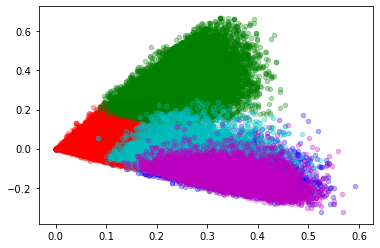

In [209]:
project4_functions.display_cluster(X, km=kmeans, num_clusters=5) #(X,km=[],num_clusters=0)

In [210]:
kmwhole = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1,
                verbose=True)
kmwhole.fit(X)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 6548.637535071272
start iteration
done sorting
end inner loop
Iteration 1, inertia 6053.770796479654
start iteration
done sorting
end inner loop
Iteration 2, inertia 5894.050366758559
start iteration
done sorting
end inner loop
Iteration 3, inertia 5816.697572408774
start iteration
done sorting
end inner loop
Iteration 4, inertia 5774.192954601584
start iteration
done sorting
end inner loop
Iteration 5, inertia 5750.080433281232
start iteration
done sorting
end inner loop
Iteration 6, inertia 5735.884126836331
start iteration
done sorting
end inner loop
Iteration 7, inertia 5727.495757190254
start iteration
done sorting
end inner loop
Iteration 8, inertia 5722.268670572887
start iteration
done sorting
end inner loop
Iteration 9, inertia 5718.642057734058
start iteration
done sorting
end inner loop
Iteration 10, inertia 5715.872927865592
start iteration
done sorting
end inner loop
Iteration 11, iner

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=10, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=True)

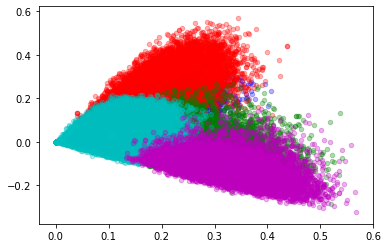

In [211]:
project4_functions.display_cluster(X, km=kmwhole, num_clusters=5) #not minibatch

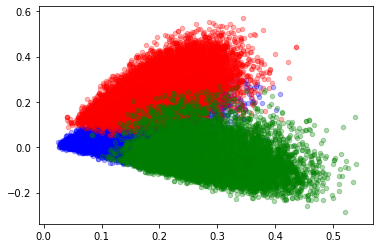

In [212]:
#lots of overlap, try 3 clusters
project4_functions.display_cluster(X, km=kmwhole, num_clusters=3) 

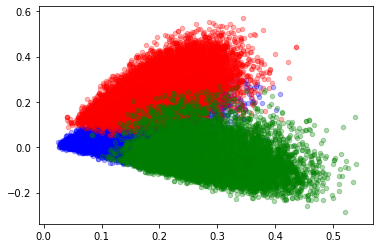

In [213]:
#sharp tip? -- points lie above 0, in all dimensions

project4_functions.display_cluster(X, km=kmwhole, num_clusters=3) #(non-minibatch)

#### Kmeans on NMF 10 topics

In [222]:
X = nmf_model.fit_transform(ingr_tfidf_n) #vectorized

k=10 #arbitrary for now, better if gridsearch on lsa/nmf to find best k? how?**

#minibatch (change var name)
kmeans_mn = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=True)

kmeans_mn.fit(X)

Init 1/1 with method: k-means++
Inertia for init 1/1: 0.134868
Minibatch iteration 1/12500: mean batch inertia: 0.000146, ewa inertia: 0.000146 
Minibatch iteration 2/12500: mean batch inertia: 0.000141, ewa inertia: 0.000146 
Minibatch iteration 3/12500: mean batch inertia: 0.000133, ewa inertia: 0.000146 
Minibatch iteration 4/12500: mean batch inertia: 0.000127, ewa inertia: 0.000145 
Minibatch iteration 5/12500: mean batch inertia: 0.000129, ewa inertia: 0.000145 
Minibatch iteration 6/12500: mean batch inertia: 0.000126, ewa inertia: 0.000145 
Minibatch iteration 7/12500: mean batch inertia: 0.000127, ewa inertia: 0.000144 
Minibatch iteration 8/12500: mean batch inertia: 0.000125, ewa inertia: 0.000144 
Minibatch iteration 9/12500: mean batch inertia: 0.000128, ewa inertia: 0.000144 
Minibatch iteration 10/12500: mean batch inertia: 0.000119, ewa inertia: 0.000143 
Minibatch iteration 11/12500: mean batch inertia: 0.000128, ewa inertia: 0.000143 
Minibatch iteration 12/12500: mea

Minibatch iteration 201/12500: mean batch inertia: 0.000115, ewa inertia: 0.000119 
Minibatch iteration 202/12500: mean batch inertia: 0.000120, ewa inertia: 0.000119 
Minibatch iteration 203/12500: mean batch inertia: 0.000115, ewa inertia: 0.000119 
Minibatch iteration 204/12500: mean batch inertia: 0.000116, ewa inertia: 0.000119 
Minibatch iteration 205/12500: mean batch inertia: 0.000118, ewa inertia: 0.000119 
Minibatch iteration 206/12500: mean batch inertia: 0.000122, ewa inertia: 0.000119 
Minibatch iteration 207/12500: mean batch inertia: 0.000115, ewa inertia: 0.000119 
Minibatch iteration 208/12500: mean batch inertia: 0.000125, ewa inertia: 0.000119 
Minibatch iteration 209/12500: mean batch inertia: 0.000119, ewa inertia: 0.000119 
Minibatch iteration 210/12500: mean batch inertia: 0.000113, ewa inertia: 0.000119 
Minibatch iteration 211/12500: mean batch inertia: 0.000119, ewa inertia: 0.000119 
Minibatch iteration 212/12500: mean batch inertia: 0.000118, ewa inertia: 0.

Minibatch iteration 302/12500: mean batch inertia: 0.000117, ewa inertia: 0.000117 
Minibatch iteration 303/12500: mean batch inertia: 0.000116, ewa inertia: 0.000117 
Minibatch iteration 304/12500: mean batch inertia: 0.000118, ewa inertia: 0.000117 
Minibatch iteration 305/12500: mean batch inertia: 0.000115, ewa inertia: 0.000117 
Minibatch iteration 306/12500: mean batch inertia: 0.000115, ewa inertia: 0.000117 
Minibatch iteration 307/12500: mean batch inertia: 0.000116, ewa inertia: 0.000117 
Minibatch iteration 308/12500: mean batch inertia: 0.000120, ewa inertia: 0.000117 
Minibatch iteration 309/12500: mean batch inertia: 0.000117, ewa inertia: 0.000117 
Minibatch iteration 310/12500: mean batch inertia: 0.000117, ewa inertia: 0.000117 
Minibatch iteration 311/12500: mean batch inertia: 0.000114, ewa inertia: 0.000117 
Minibatch iteration 312/12500: mean batch inertia: 0.000118, ewa inertia: 0.000117 
Minibatch iteration 313/12500: mean batch inertia: 0.000118, ewa inertia: 0.

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=True)

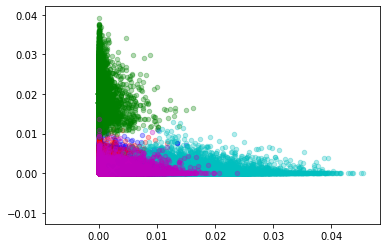

In [223]:
project4_functions.display_cluster(X, km=kmeans_mn, num_clusters=5) #(X,km=[],num_clusters=0)

Because dimensions are reduced using NMF, it makes sense all clusters only have points above 0

In [ ]:
#visualize in High-d?

In [ ]:
#kmn = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, verbose=True) # non minibatch

#### *Concept  **Kmeans clustering and cosine similarity** (write blog post? appendix?)

Current clusters without normalization takes length of doc into account; want to see distr of topics in content, so normalize vector length, then cluster and compare

when clustering, can either use methods that allow for cosine sim as a measure of doc similarity, or use Kmeans (method only has Euclidean dist, after normalization, use it to approx cosine similarity)

  long documents are long vectors, more words; causing documents with similar lengths to be clustered together (short vectors all close together).

### Normalize the dim-reduced vectors in topic space
(before trying clustering again)

In [214]:
from sklearn.preprocessing import normalize
#accepts both dense array-like and sparse matrices from scipy.sparse as input

#X = lsa_rb_tf_lem.fit_transform(ingr_tfidf_n) #vectorized lsa output
X_normalized = normalize(X, norm='l2') #l2 by default

In [215]:
#try minibatch kmeans again, same settings
kmmini = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=True)
kmmini.fit(X_normalized)

Init 1/1 with method: k-means++
Inertia for init 1/1: 286.420984
Minibatch iteration 1/12500: mean batch inertia: 0.285912, ewa inertia: 0.285912 
Minibatch iteration 2/12500: mean batch inertia: 0.281071, ewa inertia: 0.285834 
Minibatch iteration 3/12500: mean batch inertia: 0.276813, ewa inertia: 0.285689 
Minibatch iteration 4/12500: mean batch inertia: 0.291780, ewa inertia: 0.285787 
Minibatch iteration 5/12500: mean batch inertia: 0.278912, ewa inertia: 0.285677 
Minibatch iteration 6/12500: mean batch inertia: 0.279234, ewa inertia: 0.285573 
Minibatch iteration 7/12500: mean batch inertia: 0.284967, ewa inertia: 0.285564 
Minibatch iteration 8/12500: mean batch inertia: 0.272653, ewa inertia: 0.285356 
Minibatch iteration 9/12500: mean batch inertia: 0.280254, ewa inertia: 0.285274 
Minibatch iteration 10/12500: mean batch inertia: 0.279842, ewa inertia: 0.285187 
Minibatch iteration 11/12500: mean batch inertia: 0.276846, ewa inertia: 0.285053 
Minibatch iteration 12/12500: m

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=True)

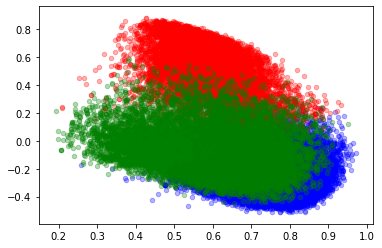

In [216]:
project4_functions.display_cluster(X_normalized, km=kmmini, num_clusters=3) #(minibatch)

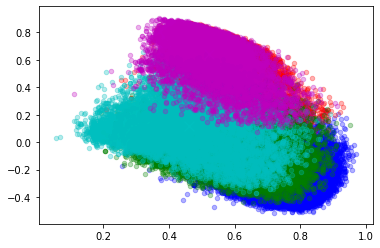

In [217]:
#Also, overlap does not justify reducing the number of clusters, because we are forcing high dimentions into 2D for plotting
#--losing info! Instead, UMAP or t-SNE for visualization?
project4_functions.display_cluster(X_normalized, km=kmmini, num_clusters=5) #(minibatch)

In [218]:
km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1,
                verbose=True)
km.fit(X_normalized)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 40565.9594924465
start iteration
done sorting
end inner loop
Iteration 1, inertia 37542.40245862269
start iteration
done sorting
end inner loop
Iteration 2, inertia 36142.82238111724
start iteration
done sorting
end inner loop
Iteration 3, inertia 35327.96022000612
start iteration
done sorting
end inner loop
Iteration 4, inertia 34909.54364260575
start iteration
done sorting
end inner loop
Iteration 5, inertia 34695.46761997683
start iteration
done sorting
end inner loop
Iteration 6, inertia 34586.30371296968
start iteration
done sorting
end inner loop
Iteration 7, inertia 34529.299615139236
start iteration
done sorting
end inner loop
Iteration 8, inertia 34497.64760673222
start iteration
done sorting
end inner loop
Iteration 9, inertia 34477.72288313482
start iteration
done sorting
end inner loop
Iteration 10, inertia 34464.234994979626
start iteration
done sorting
end inner loop
Iteration 11, ine

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=10, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=True)

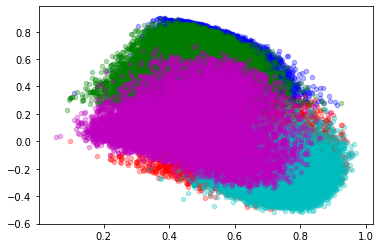

In [219]:
project4_functions.display_cluster(X_normalized, km=km, num_clusters=5) #(non-minibatch)
#cone/fan shape as expected from normalization?

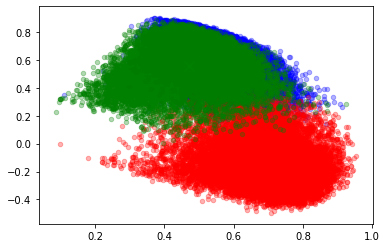

In [220]:
project4_functions.display_cluster(X_normalized, km=km, num_clusters=3) #non-minibatch

In [166]:
#(plot inertia curve, find elbow for best num of clusters? - inertia is heuristic, don't have to do it)

In [ ]:
#Nov 11. Roberto:
#**Try to *normalize* each vector before doing the cluster.  --normalize

#**One idea is to first cluster so you reduce the number of documents to a subset, 
#and then do the cosine similarity with a specific cluster. 
#only look at cos-sim between one doc and every point in one cluster??

# need to convert between Euclidean and cosine similarity - normalize


In [ ]:
#how to interpret? 
#how to get rec out of same cluster? -- need to assign recipe to cluster first

In [ ]:
#other clustering algorithms that can use cosine similarity: DBSCAN and hierarchical (ward?)

### UMAP for high-D visualization of clusters?
UMAP more efficient than t-SNE -- how to use? nice visuals but not needed for rec; also might be hard to interpret
https://pair-code.github.io/understanding-umap/

-----

In [ ]:
#*alt: topic modelling and topic classifier? (NLP_Overview ppt) 
# - t-SNE visualization of clusters; wordcloud

# LDA, topic coherence, doc-topic distribution and most representative doc for each topic
    # https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# "if words repeated across docs, k is likely too large?"

### Rec based on Flavor-similarity** future work


In [ ]:
#**LSA/NMF on rb data; 
#compare similarity in topic space(cos sim) vs. in vector space(which vectors? -- word vectors)(Chad)
#TF-IDF vectors, based on words* (sth to try)
#can't just look at doc-word matrix, do dot product of one doc to another to see how similar they are in word vector space

In [ ]:
##*Aside: make wordcloud for words in each topic? nice visuals to present
#also t-SNE visualization of clusters? (data scientist/wiki repo)

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords_ingr,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = project4_functions.display_topics(nmf_model, vectorizer.get_feature_names(), 20)
##** need show_topics option in lda? don't have this in NMF
#topics = lda_model.show_topics(formatted=False)


fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()